# Notes

In [1]:
# 1. Check iter_cb() function of lmfit - possibility to run anything at each iteration of fitting. 
# Good to input progressbar or some fancy stuff

# 2. ! Now I am feeding PC activity from the average of whole population. That means I am not capturing trends from
# depressors and sensitisors. Maybe, we need to add sub-populations activities to the model?

# 3. Look for different activation functions (examples from neuron networks). Check papers.

# Imports

In [2]:
%%time
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from lmfit import minimize, Parameter, Parameters, report_fit
from IPython import display
#from progressbar import progressbar
#from numba import jit


CPU times: total: 1.38 s
Wall time: 2.49 s


# Model diagram

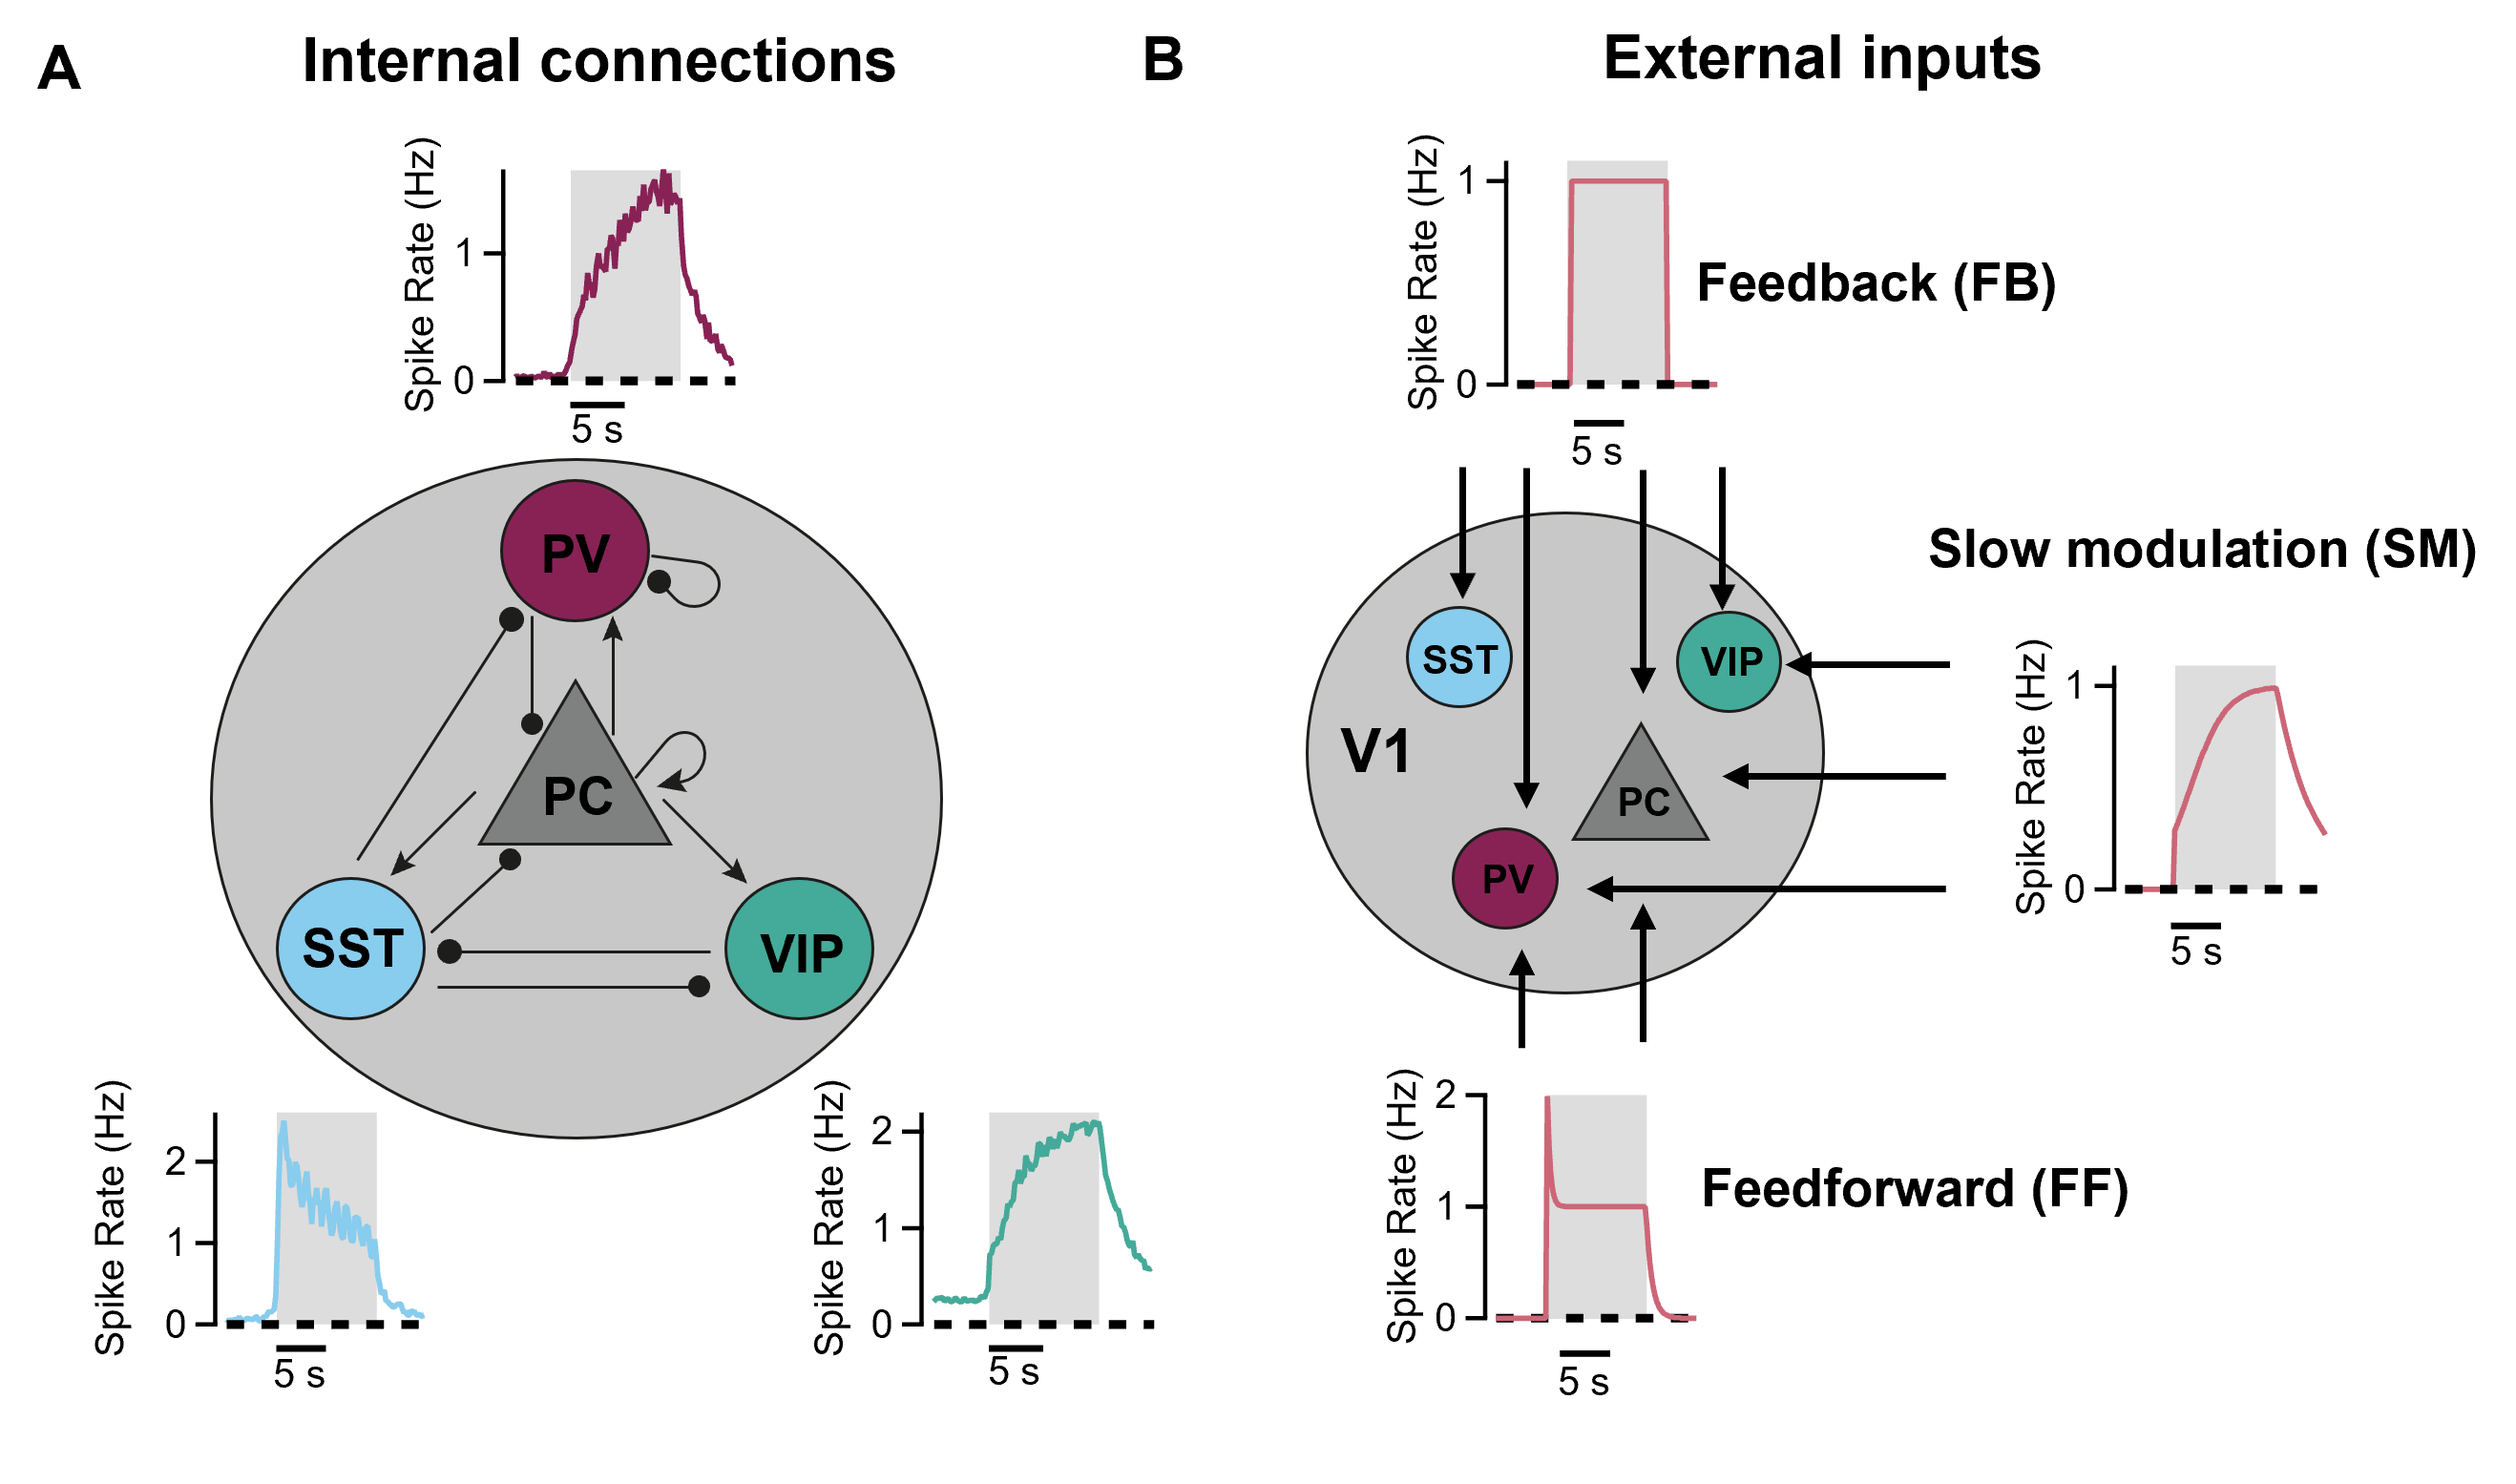

In [3]:
display.Image(r'Model_diagram.png')

In [4]:
# count = 0

# Functions

In [5]:
def exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 1, amp = 1):
    if (t < stim) or (t > stim + inter):
        h = base
    else:
        h = amp*np.exp(-(t-stim)*decay)
    return h

In [6]:
def invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 1, amp = 1, delta = 0):
    if (t < stim) or (t > stim + inter):
        h = base
    else:
        h = (amp)*(t-stim+delta)**(-decay)
    return h

In [7]:
def Step(t, stim = 5, inter = 10, amp = 1.0, base = 0, k = 1, delay = 0, decay_f = 0):
    """
    Step-like output.
    """
    
    if (t < stim + delay):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    # elif (t > stim + inter):
    #     h = amp*np.exp(-(t - stim - inter)*decay_f) + base
    elif (t > stim + inter):
        h = amp * np.exp(-(t - stim - inter)*decay_f)
    else:
        h = amp*(t - stim - delay)*k*0.164745 + amp
    
    return h

In [8]:
def Step_1(t, stim = 5, k = 0, inter = 10, amp = 1.0, base = 1):
    """
    Step-like output.
    """
    
    if (t < stim) or (t > stim + inter):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    else:
        h = amp*(t - stim)*k*0.164745 + amp
    
    return h

In [9]:
def Sigm(t, stim = 5, inter = 10, ampl = 1.0, base = 0, rate = 1, delay = 0, decay_s = 1, dt = 0):
    """
    Step-like output.
    """
    
    if (t < stim):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    elif (t > stim + inter + dt):
        h = (base + (ampl/(1 + np.exp((delay-inter - dt)/rate))))*np.exp(-(t - stim - inter - dt)*decay_s) + base
    
    else:
        h = base + (ampl/(1 + np.exp((stim + delay - t)/rate))) #Actualy rate here is time constant, where 1/rate is actual rate
        
    
    return h

In [10]:
def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0, s_start = 0.1, k = 0.1):
    if (t < stim + delay):
        h = b
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    elif (t > stim + inter):
        h = (b + base + ampl*np.exp(-(inter-delay)*decay)+ (inter - delay - s_start)*k)*np.exp(-(t - stim - inter)*decay_ff)
    elif ((t >= stim + delay) and (t < stim + delay + s_start)):
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
    else:
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)+ ((t - stim - delay - s_start)*k)
        
    return h

In [11]:
 def f_e_avg(t, data):
     """
    
     """    
    
     return np.interp(t, t_exp, data)

In [12]:
# def f_p(t, data):
#     """
    
#     """    
    
#     return np.interp(t, t_exp, data)

In [13]:
# def f_s(t):
#     """
    
#     """
    
#     return np.interp(t, t_exp, data_sst) 

In [14]:
# def f_v_f(t, data):
#     """
    
#     """    
    
#     return np.interp(t, t_exp, data)

In [15]:
# @jit(parallel=True, fastmath=True)
def model_step(t,
               y,
               w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18,
               tau_0, tau_1, tau_2, tau_3,
               threshold,
               power,
               q,
               i_0, i_1, i_2, i_3,
               r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
               ):
    """
    Builds differential equation model of visual cortex network with step input h
    """
    
            
    f_e, f_p, f_s, f_v, f_e_o, f_p_o, f_s_o, f_v_o = y
    
    ff_e = (min(max((i_0 + w_0 * f_e + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p - w_4 * f_s), threshold), 25))
    #ff_e_d = (min(max((i_d_0 + w_d_0 * f_e + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1) + w_d_2 *0* Sigm(t, rate = r_1, delay = delay_2) + w_d_3 * Step(t, k = 0, delay = delay_3) - w_d_4 * f_p - w_d_5 * f_s), threshold), 25))
    ff_p = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p - w_9 * f_s), threshold), 25))
    ff_s = (min(max((i_2 + w_10 * f_e + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v), threshold), 25))
    ff_v = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e - w_14 * f_s +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
        
    ff_e_o = (min(max((i_0 + w_0 * f_e_o + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p_o - w_4 * f_s_o), threshold), 25))
    ff_p_o = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e_o + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p_o - w_9 * f_s_o), threshold), 25)) #*invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1) *Step_1(t, k=-0.2) Step_1(t, amp = 1.0, k=-0.13) exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.01, amp = 1) *invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1)
    ff_s_o = (min(max((i_2 + w_10 * f_e_o + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v_o), threshold), 25))
    ff_v_o = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e_o - w_14 * f_s_o +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
    
        
    df_edt = ((q * ff_e ** power) - f_e) / tau_0
    #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
    df_pdt = ((q * ff_p ** power) - f_p) / tau_1
    df_sdt = ((q * ff_s ** power) - f_s) / tau_2
    df_vdt = ((q * ff_v ** power) - f_v) / tau_3
    
    if (t>=5): #and (t<=15):
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1 #/1.4
        df_s_odt = ((q * (ff_s_o*2.0) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
        
    else:
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
    
#     dGdt = (- G + g * D * S) / tau_e
#     dDdt = (1 - D) / tau_d + D * np.log(d) * w_13 * Step(t, amp = 1.5, base = 0.0)
#     dSdt = (1 - S) / tau_s + S * np.log(s) *  w_13 * Step(t, amp = 1.5, base = 0.0)

    dydt = [df_edt, df_pdt, df_sdt, df_vdt, df_e_odt, df_p_odt, df_s_odt, df_v_odt]
    
    return dydt

In [16]:
names = ['w_PC_PC', # w_0
         'w_EX_PC', # w_1
         'w_SI_PC', # w_2
         'w_PV_PC', # w_3
         'w_SS_PC', # w_4
         'w_PC_PV', # w_5
         'w_EX_PV', # w_6
         'w_SI_PV', # w_7
         'w_PV_PV', # w_8
         'w_SS_PV', # w_9
         'w_PC_SS', # w_10
         'w_ST_SS', # w_11
         'w_VI_SS', # w_12
         'w_PC_VI', # w_13
         'w_SS_VI', # w_14
         'w_SI_VI', # w_15
         'w_ST_PC', # w_16
         'w_PC_PC', # w_17
         'w_PC_PC', # w_18
         'w_PC_PC', # w_19
         'w_PC_PC'] # w_20

In [17]:
#@njit(parallel=True, fastmath=True)
def exp_time(start, step, count, endpoint=False):
    """
    Returns NumPy array of experimental timepoints of data
    """
    stop = start+(step*count)
    return np.linspace(start, stop, count, endpoint=endpoint)

In [18]:
#@jit(parallel=True, fastmath=True)
def odesol_step(tt, init, params): 
    """
    Solves ODEs system for step input
    """
    y_init = init
    w_0 = params['w_0'].value
    w_1 = params['w_1'].value
    w_2 = params['w_2'].value
    w_3 = params['w_3'].value
    w_4 = params['w_4'].value
    w_5 = params['w_5'].value
    w_6 = params['w_6'].value
    w_7 = params['w_7'].value
    w_8 = params['w_8'].value
    w_9 = params['w_9'].value
    w_10 = params['w_10'].value
    w_11 = params['w_11'].value
    w_12 = params['w_12'].value
    w_13 = params['w_13'].value
    w_14 = params['w_14'].value
    w_15 = params['w_15'].value
    w_16 = params['w_16'].value
    w_17 = params['w_17'].value
    w_18 = params['w_18'].value
    
    tau_0 = params['tau_0'].value
    tau_1 = params['tau_1'].value
    tau_2 = params['tau_2'].value
    tau_3 = params['tau_3'].value
    threshold = params['threshold'].value
    power = params['power'].value
    q = params['q'].value
    i_0 = params['i_0'].value
    i_1 = params['i_1'].value
    i_2 = params['i_2'].value
    i_3 = params['i_3'].value
    ampl_1 = params['ampl_1'].value
#     ampl_2 = params['ampl_2'].value
#     ampl_3 = params['ampl_3'].value
#     kl = params['kl'].value
#     kl_1 = params['kl_1'].value
#     kl_2 = params['kl_2'].value
#     s_1 = params['s_1'].value
#     s_2 = params['s_2'].value
    r_1 = params['r_1'].value
    delay_1 = params['delay_1'].value
    delay_2 = params['delay_2'].value
    delay_3 = params['delay_3'].value
    decay = params['decay'].value
    decay_s = params['decay_s'].value
    decay_f = params['decay_f'].value
    decay_ff = params['decay_ff'].value
    ampl = params['ampl'].value
    base = params['base'].value
    base_sigm = params['base_sigm'].value
    s_start = params['s_start'].value
    k = params['k'].value
   
    
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    
    return sol

In [19]:
def odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, start_s, k):
    
    y_init = init
    tt = t_exp
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    return sol

In [20]:
def simulate_step(tt, init, params):
    """
    Simulates model
    """
    
#     global count, max_nfev, data_pv
#     #f_e_ = []
#     f_pv_ = []
#     f_sst_ = []
#     f_vip_ = []
    
    sol = odesol_step(tt, init, params)
    
    #print('\r',' ',sol.message, 'count # ', count, '/', end='')
    #print(f'\r {sol.message} Count # {count}/{max_nfev}', end='')
    #print(count)
    #count += 1
    
#     for i in sol.t:
#         #f_e_.append(f_e_avg(i))
#         f_pv_.append(f_p(i, data_pv))
#         f_sst_.append(f_s(i))
#         f_vip_.append(f_v(i))
    
#     print(sol.t)
#     print(sol.y[0])
#     print(np.array(f_pv_))
#     print(np.array(f_sst_))
#     print(np.array(f_vip_))
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [21]:
def simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                   tau_0, tau_1, tau_2, tau_3,
                   threshold,
                   power, 
                   q,
                   i_0, i_1, i_2, i_3,
                   r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k):
    """
    Simulates model
    """
    
#     global count, max_nfev, data_pv
#     #f_e_ = []
#     f_pv_ = []
#     f_sst_ = []
#     f_vip_ = []
    
    sol = odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k)
    
    #print('\r',' ',sol.message, 'count # ', count, '/', end='')
    #print(f'\r {sol.message} Count # {count}/{max_nfev}', end='')
    #print(count)
    #count += 1
    
#     for i in sol.t:
#         #f_e_.append(f_e_avg(i))
#         f_pv_.append(f_p(i, data_pv))
#         f_sst_.append(f_s(i))
#         f_vip_.append(f_v(i))
    
#     print(sol.t)
#     print(sol.y[0])
#     print(np.array(f_pv_))
#     print(np.array(f_sst_))
#     print(np.array(f_vip_))
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [22]:
def residual_step(params, tt, init, data_pc, data_pv, data_sst, data_vip):
    """
    Difference between model and data for further minimization
    """
    global count, max_nfev
    
    weights_sst=np.float32(np.zeros_like(data_pc))
    weights_vip=np.float32(np.zeros_like(data_pc))
    weights_pv=np.float32(np.zeros_like(data_pc))
    weights_pc=np.float32(np.zeros_like(data_pc))
    
    weights_pv[0:24]=1.
    weights_pv[24:36]=0.05
    weights_pv[36:]=1. #:93
    
    #weights_1[85:]=1.
    #weights[50:80]=1.
    weights_sst[0:24]=1.
    weights_sst[24:30]=1.0
    weights_sst[30:]=1.0
    
    weights_vip[0:24]=1.
    weights_vip[24:30]=1.0
    weights_vip[30:]=1.0
    
    weights_pc[0:24]=1.
    weights_pc[24:30]=0.05
    weights_pc[30:38]=1.
    weights_pc[38:93]=1.
    weights_pc[93:]=1.

    # weights_pv = weights_pv * 3
    # weights_sst = weights_sst * 3
    # weights_pc = weights_pc * 3
    # weights_vip = weights_vip * 3
    
    model = simulate_step(tt, init, params)
    pc_r = (np.float32(np.array(model['f_e'].values - data_pc))*weights_pc).ravel() #/pc_all_err_new
    pv_r = (np.float32(np.array(model['f_pv'].values - data_pv))*weights_pv).ravel() #/pv_err_new
    sst_r = (np.float32(np.array(model['f_sst'].values - data_sst))*weights_sst).ravel() # /sst_err_new
    vip_r = (np.float32(np.array(model['f_vip'].values - data_vip))*weights_vip).ravel() # /vip_err_new
    
    arr = np.concatenate((pc_r,pv_r,sst_r,vip_r), axis=0)
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylim(0, 2.0)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    
    # plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
    # plt.plot(t_exp, curve, color = 'green', label='input')
    
    
    
    return arr

In [23]:
def residual_ad(params, tt, init, data_pc, data_pc_na):
    """
    Difference between model and data for further minimization
    """
    global count, max_nfev
    
    weights=np.float32(np.zeros_like(data_pc))
    weights_1=np.float32(np.zeros_like(data_pc))
    weights_2=np.float32(np.zeros_like(data_pc))
    weights_1[0:24]=1.
    weights_1[24:35]=0.05
    weights_1[35:91]=1.
    #weights_1[85:]=1.
    #weights[50:80]=1.
    weights[0:24]=1.
    weights[24:30]=0.05
    weights[30:91]=1.
    weights_2[0:24]=1.
    weights_2[24:36]=0.05
    weights_2[30:36]=3.
    weights_2[36:91]=1.
    
    model = simulate_step(tt, init, params)
    #pc_r = np.float32(np.array(model['f_e'].values - data_pc))*weights_2.ravel() #/np.array(pc_sen_err_new)
    pc_d_r = np.array(model['f_e_d'].values - data_pc_na)*weights_2.ravel()
    #pv_r = np.float32(np.array(model['f_pv'].values - data_pv))*weights_1.ravel()
    #sst_r = np.float32(np.array(model['f_sst'].values - data_sst))*weights.ravel()
    #vip_r = np.float32(np.array(model['f_vip'].values - data_vip))*weights.ravel()
    
    #arr = np.concatenate((pc_r,pv_r,sst_r,vip_r), axis=0)
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylim(0, 2.0)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    
    # plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
    # plt.plot(t_exp, curve, color = 'green', label='input')
    
    
    
    return pc_d_r

In [24]:
def slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k):
    
    model_local = simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k)
    
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    ax[0, 0].plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
    ax[0, 0].plot(t_exp, model_local['f_e'].values, color='blue', label='fit', linewidth=3)
    ax[0, 0].plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
    ax[0, 0].plot(t_exp, model_local['f_e_o'].values, color='red', label='fit', linewidth=3)
    
    ax[1, 0].plot(t_exp, data_pv, color='black', marker='o', label='f_pc(t)')
    ax[1, 0].plot(t_exp, model_local['f_pv'].values, color='blue', label='fit', linewidth=3)
    
    ax[0, 1].plot(t_exp, data_sst, color='black', marker='o', label='f_pc(t)')
    ax[0, 1].plot(t_exp, model_local['f_sst'].values, color='blue', label='fit', linewidth=3)
    
    ax[1, 1].plot(t_exp, data_vip, color='black', marker='o', label='f_pc(t)')
    ax[1, 1].plot(t_exp, model_local['f_vip'].values, color='blue', label='fit', linewidth=3)
    plt.show()
    

In [25]:
def RMSE_full(params, init, data_pc, data_pv, data_sst, data_vip):

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(len(data_pc)):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum_norm = np.sqrt((sum)/(len(data_pc)*4))

    return sum_norm

In [26]:
def RMSE_full_1(params, init, data_pc, data_pv, data_sst, data_vip):

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(31,91):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum_norm = np.sqrt((sum)/(len(data_pc)*4))

    return sum_norm

# Experimental data

In [27]:
pc_sen = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Sen_Avg.txt')
pc_dep = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Dep_Avg.txt')
#f_e_exp_3 = np.loadtxt(r'Experimental data\Updated_again\PC_AllFil_Sess1_firingrate_10_11_2023.txt')
pc_na = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_NA_Avg.txt')
pc_all = np.loadtxt(r'Experimental data\Updated_again\QA_Avg_Sess1_PC_NoLoco.txt')
pc_sen_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Sen_SEM.txt')
pc_dep_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Dep_SEM.txt')
pc_na_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_NA_SEM.txt')
pc_opto_pv_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVArChT1_Opto.txt')
pc_opto_pv_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVChR1_Opto.txt')
pc_opto_sst_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTArchT1_Opto.txt')
pc_opto_sst_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTChR1_Opto.txt')
pc_all_err = np.loadtxt(r'Experimental data\Updated_again\QA_SEM_Sess1_PC_NoLoco.txt')
#print(f_e_exp_1)
t_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pc_sen))
#print(t_exp_1)
print(len(pc_sen), len(t_exp_1))

183 183


In [28]:
print(pc_all_err)

[0.04138852 0.04408449 0.02766528 0.02123942 0.05342474 0.04646768
 0.03583075 0.02497875 0.02669525 0.03732242 0.03538563 0.06944742
 0.04342619 0.05550382 0.03053026 0.0270863  0.04421911 0.0519935
 0.06195007 0.02497875 0.04903376 0.07017222 0.0160582  0.05533056
 0.05372343 0.02195912 0.02766528 0.05008546 0.05331051 0.02264925
 0.02497875 0.05747066 0.0270863  0.01925212 0.04995749 0.04529849
 0.03583075 0.05254457 0.05555322 0.04179525 0.05042813 0.03538563
 0.04050642 0.01925212 0.04794629 0.05924391 0.05276166 0.07238728
 0.05144541 0.05533056 0.06115778 0.04499468 0.04722891 0.05625926
 0.05498241 0.08042377 0.04713847 0.04219445 0.04461029 0.04613193
 0.09003168 0.13532345 0.13907906 0.15275608 0.172609   0.15634939
 0.16870554 0.13665149 0.12226196 0.11564852 0.16386357 0.15487838
 0.13690109 0.13960951 0.1704124  0.1382713  0.12024845 0.13759842
 0.10641499 0.11296462 0.10429432 0.1134412  0.11885382 0.08725679
 0.12733959 0.11152538 0.13010416 0.08339336 0.098545   0.10855

In [29]:
pv = np.loadtxt(r'Experimental data\Updated_again\QA_Avg_Sess1_PV_NoLoco.txt')
pv_err = np.loadtxt(r'Experimental data\Updated_again\QA_SEM_Sess1_PV_NoLoco.txt')
#print(f_e_exp_1)
t_pv_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pv))
#print(t_exp_1)
print(len(pv), len(t_pv_exp_1))

366 366


In [30]:
print(pv_err)

[0.06257732 0.08803556 0.09017192 0.         0.02085911 0.
 0.14489199 0.06872171 0.06257732 0.06257732 0.06257732 0.
 0.06257732 0.06257732 0.07484613 0.06257732 0.07150142 0.10888773
 0.10725212 0.06257732 0.02085911 0.02085911 0.         0.06257732
 0.06257732 0.02085911 0.10725212 0.06872171 0.02085911 0.06257732
 0.06575583 0.         0.         0.         0.06575583 0.02934519
 0.         0.06257732 0.09220968 0.06257732 0.04171821 0.06575583
 0.06257732 0.02085911 0.         0.         0.02085911 0.06257732
 0.06575583 0.02085911 0.         0.02085911 0.02934519 0.09220968
 0.02085911 0.         0.02085911 0.02085911 0.         0.08731183
 0.13369912 0.18114626 0.29953585 0.27993525 0.22015583 0.22193966
 0.19613847 0.16338709 0.12695241 0.15200575 0.22690771 0.1931815
 0.22202133 0.21006339 0.18046945 0.13036942 0.1681715  0.18649663
 0.19593039 0.16013695 0.18355718 0.15396107 0.19854996 0.17300698
 0.23075019 0.15897231 0.19694558 0.15200575 0.2076983  0.18162102
 0.23923647 

In [31]:
for i, v in np.ndenumerate(pv_err):
    if v == 0:
        pv_err[i] = 0.001

In [32]:
# pv_new = f_pv_exp_1[0:122]
# t_ca_new = t_pv_exp_1[0:122]
# plt.plot(t_ca_new, pv_new, marker = 'x', label = 'pv', color='orange')
# plt.legend()
# plt.show()

In [33]:
# a = [f_pv_exp_1[121]]
# b = [t_pv_exp_1[121]]
# c = []
# for i in range(0,61):
#     a.append(a[-1]*np.exp(-1.0392*0.164745))
#     b.append(b[-1] + 0.164745)

# for i in t_exp_1:
#     c.append(Step(i, stim = 5, amp = 0.5, base = 0.0))
    

# pv_new = np.append(pv_new, a)
# t_ca_new = np.append(t_ca_new, b)

# plt.plot(t_exp_1, f_e_exp_4, marker = 'x', label = 'pc_avg')
# plt.plot(t_exp_1, f_pv_exp_1, marker = 'x', label = 'pv_old')
# plt.plot(t_exp_1, c)
# plt.plot(t_ca_new, pv_new, marker = 'x', label = 'pv_new')
# plt.legend()
# plt.show()

In [34]:
sst = np.loadtxt(r'Experimental data\Updated_again\QA_Avg_Sess1_SST_NoLoco.txt')
sst_err = np.loadtxt(r'Experimental data\Updated_again\QA_SEM_Sess1_SST_NoLoco.txt')
#print(f_e_exp_1)
t_sst_exp_1 = exp_time(start=0.0, step=0.164745, count=len(sst))
#print(t_exp_1)
print(len(sst), len(t_sst_exp_1))

366 366


In [35]:
print(sst_err, len(sst_err))

[0.08845786 0.         0.04934959 0.08859583 0.03467936 0.07531092
 0.0246748  0.         0.08557487 0.0246748  0.02861835 0.07773902
 0.         0.0246748  0.07531092 0.         0.0246748  0.07773902
 0.07608062 0.04934959 0.05249103 0.         0.07402439 0.0246748
 0.11436304 0.07773902 0.         0.0246748  0.07402439 0.04422893
 0.         0.03701219 0.04422893 0.07402439 0.01480488 0.
 0.0246748  0.         0.0246748  0.03701219 0.07773902 0.08235207
 0.03467936 0.07402439 0.07531092 0.01480488 0.02861835 0.10558711
 0.         0.16512255 0.10482836 0.10403808 0.10403808 0.10884016
 0.14566259 0.10650149 0.08972342 0.05490138 0.04520305 0.11271158
 0.17222921 0.26725419 0.31155693 0.34146494 0.40430653 0.32219698
 0.34343315 0.38991607 0.33016239 0.33980408 0.31502793 0.31692032
 0.33309759 0.36365076 0.28144284 0.27137664 0.27619434 0.22461633
 0.28676118 0.28093143 0.25042633 0.24724815 0.18502726 0.26387441
 0.23622664 0.32712099 0.29356453 0.24283418 0.30917616 0.306904
 0.283

In [36]:
for i, v in np.ndenumerate(sst_err):
    if v == 0:
        sst_err[i] = 0.001

print(sst_err)

[0.08845786 0.001      0.04934959 0.08859583 0.03467936 0.07531092
 0.0246748  0.001      0.08557487 0.0246748  0.02861835 0.07773902
 0.001      0.0246748  0.07531092 0.001      0.0246748  0.07773902
 0.07608062 0.04934959 0.05249103 0.001      0.07402439 0.0246748
 0.11436304 0.07773902 0.001      0.0246748  0.07402439 0.04422893
 0.001      0.03701219 0.04422893 0.07402439 0.01480488 0.001
 0.0246748  0.001      0.0246748  0.03701219 0.07773902 0.08235207
 0.03467936 0.07402439 0.07531092 0.01480488 0.02861835 0.10558711
 0.001      0.16512255 0.10482836 0.10403808 0.10403808 0.10884016
 0.14566259 0.10650149 0.08972342 0.05490138 0.04520305 0.11271158
 0.17222921 0.26725419 0.31155693 0.34146494 0.40430653 0.32219698
 0.34343315 0.38991607 0.33016239 0.33980408 0.31502793 0.31692032
 0.33309759 0.36365076 0.28144284 0.27137664 0.27619434 0.22461633
 0.28676118 0.28093143 0.25042633 0.24724815 0.18502726 0.26387441
 0.23622664 0.32712099 0.29356453 0.24283418 0.30917616 0.306904
 0.

In [37]:
vip = np.loadtxt(r'Experimental data\Updated_again\QA_Avg_Sess1_VIPPos_NoLoco.txt')
vip_err = np.loadtxt(r'Experimental data\Updated_again\QA_SEM_Sess1_VIP_NoLoco.txt')
#print(f_e_exp_1)
t_vip_exp_1 = exp_time(start=0.0, step=0.164745, count=len(vip))
#print(t_exp_1)
print(len(vip), len(t_vip_exp_1))

366 366


In [38]:
print(vip_err)

[0.04273073 0.06197564 0.07554329 0.08071368 0.0713327  0.07668267
 0.05321455 0.07520053 0.04705818 0.09103625 0.08939164 0.08480126
 0.06823388 0.0647673  0.07469406 0.07744208 0.08632491 0.072211
 0.08363146 0.06553507 0.10273748 0.07852429 0.0824807  0.09159262
 0.06931802 0.10167704 0.06393342 0.06721705 0.06716888 0.0766449
 0.06545485 0.0921152  0.08077375 0.07176735 0.05897753 0.06189416
 0.08165448 0.08778029 0.10220761 0.0917346  0.08639411 0.07806091
 0.07945254 0.08315157 0.07619738 0.06592672 0.09062923 0.07744535
 0.09832068 0.0861885  0.09021982 0.08483841 0.07643716 0.07277418
 0.08428596 0.08961856 0.08019947 0.08197401 0.05819454 0.10901943
 0.11151603 0.15934428 0.13109901 0.13829097 0.1371882  0.12778574
 0.13081792 0.11472042 0.13185464 0.11369048 0.13231245 0.1153643
 0.11989261 0.11870014 0.10229131 0.11631271 0.10830325 0.14056261
 0.12909065 0.11339438 0.13250027 0.12826941 0.11951887 0.08620116
 0.12634598 0.12135648 0.10627812 0.10699087 0.09635041 0.10422647

In [39]:
for i, v in np.ndenumerate(vip_err):
    if v == 0:
        vip_err[i] = 0.001



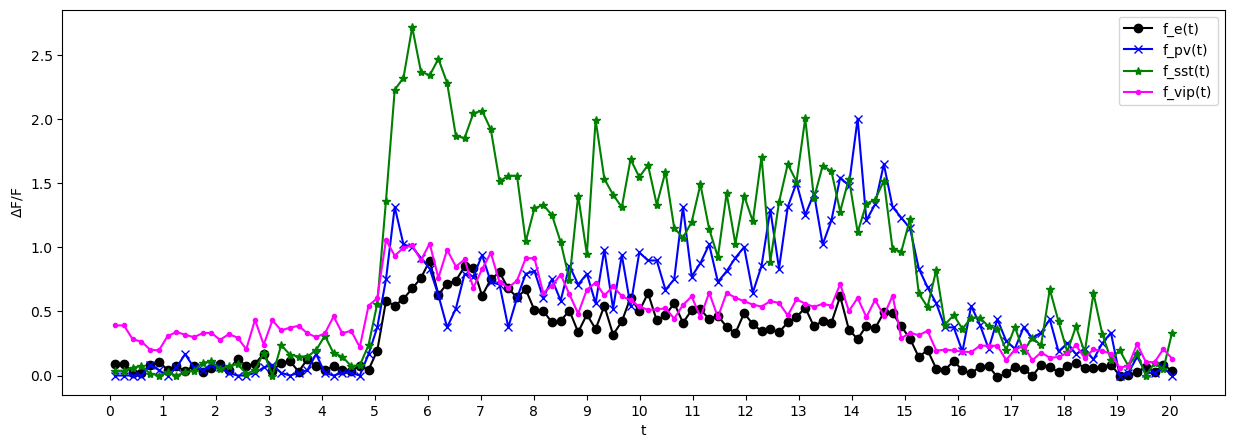

In [40]:
dt = 0.164745

t_exp_1_new = []
pc_sen_new = []
#f_e_avg_l = []
pv_new = []
#f_pv_excite = []
sst_new = []
vip_new = []
pc_na_new = []
pc_dep_new = []
pc_all_new = []
pc_sen_err_new = []
pc_dep_err_new = []
pc_na_err_new = []
pc_all_err_new = []
pv_err_new = []
sst_err_new = []
vip_err_new = []
pc_opto_pv_arch_new = []
pc_opto_pv_chr_new = []
pc_opto_sst_chr_new = []
pc_opto_sst_arch_new = []

for ind, time in np.ndenumerate(t_exp_1):
    if (time >= 5) and (time <= 25):
        t_exp_1_new.append(time - 5)
        pc_sen_new.append(pc_sen[ind])
        #f_e_avg_l.append(f_e_exp_3[ind])
        pv_new.append(pv[ind])
        sst_new.append(sst[ind])
        vip_new.append(vip[ind])
        pc_na_new.append(pc_na[ind])
        pc_dep_new.append(pc_dep[ind])
        pc_all_new.append(pc_all[ind])
        #f_pv_excite.append(pv_new[ind])
        pc_sen_err_new.append(pc_sen_err[ind])
        pc_dep_err_new.append(pc_dep_err[ind])
        pc_na_err_new.append(pc_na_err[ind])
        pv_err_new.append(pv_err[ind])
        sst_err_new.append(sst_err[ind])
        vip_err_new.append(vip_err[ind])
        pc_opto_pv_arch_new.append(pc_opto_pv_arch[ind])
        pc_opto_pv_chr_new.append(pc_opto_pv_chr[ind])
        pc_opto_sst_chr_new.append(pc_opto_sst_chr[ind])
        pc_opto_sst_arch_new.append(pc_opto_sst_arch[ind])
        pc_all_err_new.append(pc_all_err[ind])
        
        
pc_sen_new.insert(0, pc_sen_new[0])
pv_new.insert(0, pv_new[0])
sst_new.insert(0, sst_new[0])
vip_new.insert(0, vip_new[0])
pc_na_new.insert(0, pc_na_new[0])
pc_dep_new.insert(0, pc_dep_new[0])
pc_all_new.insert(0, pc_all_new[0])
pc_sen_err_new.insert(0, pc_sen_err_new[0])
pc_dep_err_new.insert(0, pc_dep_err_new[0])
pc_na_err_new.insert(0, pc_na_err_new[0])
pv_err_new.insert(0, pv_err_new[0])
sst_err_new.insert(0, sst_err_new[0])
vip_err_new.insert(0, vip_err_new[0])
pc_opto_pv_arch_new.insert(0, pc_opto_pv_arch_new[0])
pc_opto_pv_chr_new.insert(0, pc_opto_pv_chr_new[0])
pc_opto_sst_chr_new.insert(0, pc_opto_sst_chr_new[0])
pc_opto_sst_arch_new.insert(0, pc_opto_sst_arch_new[0])
pc_all_err_new.insert(0, pc_all_err_new[0])

#t_exp_1_new = np.linspace(start=0, stop=(len(pc_sen_new)-1)*dt, num=len(pc_sen_new))
t_exp_1_new.append(t_exp_1_new[-1] + dt)
        
plt.figure(figsize=(15,5))
plt.plot(t_exp_1_new, pc_all_new, color='black', marker='o', label='f_e(t)')
plt.plot(t_exp_1_new, pv_new, color='blue', marker='x', label='f_pv(t)')
plt.plot(t_exp_1_new, sst_new, color='green', marker='*', label='f_sst(t)')
plt.plot(t_exp_1_new, vip_new, color='magenta', marker='.', label='f_vip(t)')
#plt.plot(t_exp_1_new, f_pv_excite, color='orange', marker='v', label='external')

plt.legend(loc='best')
plt.ylabel(r'$\Delta$F/F')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [41]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp_1_new[30:91], data_pc_all[30:91], color='blue', marker='o', label='f_e(t)')
# plt.plot(t_exp_1_new[90:], vip_new[90:], color='black', marker='o', label='f_e(t)')

# plt.legend(loc='best')
# plt.ylabel(r'$\Delta$F/F')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,21,1))
# plt.grid()
# plt.show()

# Variables and constants

In [42]:
t = np.float32(np.array(t_exp_1_new))
t_exp = t
threshold = np.float32(0) 

power = np.float32(2.0)
q = np.float32(1.0)

ampl_1 = 1.0
# ampl_2 = 5.0
# ampl_3 = 0
# kl = 0
# kl_1 = 0
# kl_2 = 0
# s_1 = 0.10
# s_2 = 0.10

r_1 = np.float32(1.713939)
delay_1 = np.float32(0.1650418)
delay_2 = np.float32(1.73305)
delay_3 = np.float32(0.3695274)
decay = np.float32(3.324089)
decay_s = np.float32(0.2685497)
decay_f = np.float32(0.8342502)
decay_ff = np.float32(2.152722)
ampl = np.float32(1.0)
base = np.float32(1.0)
base_sigm = np.float32(0)
s_start = np.float32(0.1835884)
k = np.float32(0.03068755)

init = np.float32(np.array([0.055, 0.011, 0.017, 0.208, 0.055, 0.011, 0.017, 0.208]))
tau = np.float32(np.array([0.015, 0.0075, 0.019, 0.019]))
#tau_s = np.array([100, 1, 15, 0.5])
i = np.float32(np.array([0.29121401, 0.04328944, 0.24586516, 0.49507509]))
w = np.float32(np.array([
              0.22494800 , # w_0  PC  -> PC        
              1.10143194, # w_1  FF  -> PC
              0.24810577, # w_2  SM   -> PC
              1.97002258, # w_3  PV -> PC
              0.33357873, # w_4  SST  -> PC
              0.52302201, # w_5  PC   -> PV
              0.60092909, # w_6  FF  -> PV
              1.22499424, # w_7  SM -> PV
              1.48880306, # w_8  PV   -> PV
              0.07577982, # w_9  SST  -> PV
              1.55551425, # w_10 PC -> SST
              0.37281284, # w_11 FB  -> SST
              0.18591899, # w_12 VIP  -> SST
              0.69694172, # w_13 PC  -> VIP
              0.01562676, # w_14 SST  -> VIP
              0.00630454, # w_15 SM  -> VIP
              1.16104597, # w_16 FB  -> PC
              0.48433493, # w_17 FB  -> PV
              9.1936e-05]))# w_18 FB -> VIP


# g = 1
# d = 0.9478
# s = 0.9999
# tau_d = 0.4429
# tau_s = 13.8823
# tau_e = 2e-3

data_pc_sen = np.float32(np.array(pc_sen_new)) * 0.333 #proportion of cells relative to PC
#data_pc_avg = f_e_avg_l
data_pv = np.float32(np.array(pv_new)) #proportion of cells relative to PC
data_sst = np.float32(np.array(sst_new)) #proportion of cells relative to PC
data_vip = np.float32(np.array(vip_new)) #proportion of cells relative to PC
data_pc_na = np.float32(np.array(pc_na_new)) * 0.333 #proportion of cells relative to PC
data_pc_dep = np.float32(np.array(pc_dep_new)) * 0.333 #proportion of cells relative to PC
data_pc_all = np.float32(np.array(pc_all_new))
data_pc_opto_pv_arch = np.float32(np.array(pc_opto_pv_arch_new))
data_pc_opto_pv_chr = np.float32(np.array(pc_opto_pv_chr_new))
data_pc_opto_sst_chr = np.float32(np.array(pc_opto_sst_chr_new))
data_pc_opto_sst_arch = np.float32(np.array(pc_opto_sst_arch_new))
pv_err_new = np.array(pv_err_new)
sst_err_new = np.array(sst_err_new)
vip_err_new = np.array(vip_err_new)

#data_pv_exc = f_pv_excite

count = 0
max_nfev = 2000

"""
0.08281103 (init = 0.08305636)
    w_1:        1.51969985 (init = 1.467154)
    w_2:        1.06618999 (init = 1.397314)
    w_3:        1.95560664 (init = 1.957842)
    w_4:        0.63190096 (init = 0.6209238)
    w_5:        0.20723919 (init = 0.1732922)
    w_6:        0.92636845 (init = 0.9164389)
    w_7:        2.11169434 (init = 2.105292)
    w_8:        1.51029559 (init = 1.38118)
    w_9:        0.25013329 (init = 0.3261505)
    w_10:       0.78370724 (init = 0.8955549)
    w_11:       0.59415933 (init = 0.6046628)
    w_12:       0.14997032 (init = 0.1912277)
    w_13:       0.32398988 (init = 0.6)
    w_14:       0.19112577 (init = 0.1)
    w_15:       0.73762300 (init = 0.8316147)
    w_16:       1.14600083 (init = 1.008597)
    w_17:       0.17580747 (init = 0.2193536)
    w_18:       0.15806817 (init = 0.03681558)
"""

'\n0.08281103 (init = 0.08305636)\n    w_1:        1.51969985 (init = 1.467154)\n    w_2:        1.06618999 (init = 1.397314)\n    w_3:        1.95560664 (init = 1.957842)\n    w_4:        0.63190096 (init = 0.6209238)\n    w_5:        0.20723919 (init = 0.1732922)\n    w_6:        0.92636845 (init = 0.9164389)\n    w_7:        2.11169434 (init = 2.105292)\n    w_8:        1.51029559 (init = 1.38118)\n    w_9:        0.25013329 (init = 0.3261505)\n    w_10:       0.78370724 (init = 0.8955549)\n    w_11:       0.59415933 (init = 0.6046628)\n    w_12:       0.14997032 (init = 0.1912277)\n    w_13:       0.32398988 (init = 0.6)\n    w_14:       0.19112577 (init = 0.1)\n    w_15:       0.73762300 (init = 0.8316147)\n    w_16:       1.14600083 (init = 1.008597)\n    w_17:       0.17580747 (init = 0.2193536)\n    w_18:       0.15806817 (init = 0.03681558)\n'

In [43]:
#print(len(data_pc_sen))

In [44]:
# weights=np.zeros_like(data_pc)
# weights[18:]=1
# print(weights)

## Parameters

In [45]:
params = Parameters()
params.add('w_0', value = w[0] , vary = True, min = 0.0, max = 3.5)
params.add('w_1', value = w[1] , vary = True, min = 0.0, max = 3.5)
params.add('w_2', value = w[2] , vary = True, min = 0.0, max = 3.5)
params.add('w_3', value = w[3] , vary = True, min = 0.0, max = 3.5)
params.add('w_4', value = w[4] , vary = True, min = 0.0, max = 3.5)
params.add('w_5', value = w[5] , vary = True, min = 0.0, max = 3.5)
params.add('w_6', value = w[6] , vary = True, min = 0.0, max = 3.5)
params.add('w_7', value = w[7] , vary = True, min = 0.0, max = 3.5)
params.add('w_8', value = w[8] , vary = True, min = 0.0, max = 3.5)
params.add('w_9', value = w[9] , vary = True, min = 0.0, max = 3.5)
params.add('w_10', value = w[10] , vary = True, min = 0.0, max = 3.5)
params.add('w_11', value = w[11] , vary = True, min = 0.0, max = 3.5)
params.add('w_12', value = w[12] , vary = True, min = 0.0, max = 3.5)
params.add('w_13', value = w[13] , vary = True, min = 0.0, max = 3.5)
params.add('w_14', value = w[14] , vary = True, min = 0.0, max = 3.5)
params.add('w_15', value = w[15] , vary = True, min = 0.0, max = 3.5)
params.add('w_16', value = w[16] , vary = True, min = 0.0, max = 3.5)
params.add('w_17', value = w[17] , vary = True, min = 0.0, max = 3.5)
params.add('w_18', value = w[18] , vary = True, min = 0.0, max = 3.5)

#params.add('w_13', value = w[13] , vary = True, min = 0.1, max = 25)
params.add('tau_0', value = tau[0] , vary = False, min = 0.001, max = 0.03)
params.add('tau_1', value = tau[1] , vary = False, min = 0.001, max = 0.03)
params.add('tau_2', value = tau[2] , vary = False, min = 0.001, max = 0.03)
params.add('tau_3', value = tau[3] , vary = False, min = 0.001, max = 0.03)
params.add('threshold', value = threshold , vary = False, min = -np.inf, max = np.inf)
params.add('power', value = power , vary = False, min = 0.5, max = 2.5)
params.add('q', value = q, vary = False, min = 0.001, max = 2.5 )
params.add('i_0', value = i[0] , vary = True, min = 0.0, max = 0.7)
params.add('i_1', value = i[1] , vary = True, min = 0.0, max = 0.7)
params.add('i_2', value = i[2] , vary = True, min = 0.0, max = 0.7)
params.add('i_3', value = i[3] , vary = True, min = 0.0, max = 0.7)

params.add('ampl_1', value = ampl_1 , vary = False, min = 0.8, max = 1.5)
# params.add('ampl_2', value = ampl_2 , vary = True, min = 0, max = 15)
# params.add('ampl_3', value = ampl_3 , vary = False, min = 0, max = 7)
# params.add('kl', value = kl , vary = False, min = -15, max = 7)
# params.add('kl_1', value = kl_1 , vary = False, min = -10, max = 0)
# params.add('kl_2', value = kl_2 , vary = False, min = 0, max = 10)
# params.add('s_1', value = s_1 , vary = True, min = 0, max = 5)
# params.add('s_2', value = s_2 , vary = True, min = 0, max = 5)

params.add('r_1', value = r_1, vary = False, min = 0, max = 5)
params.add('delay_1', value = delay_1, vary = False, min = 0, max = 1.5)
params.add('delay_2', value = delay_2, vary = False, min = 0, max = 25)
params.add('delay_3', value = delay_3, vary = False, min = 0, max = 3)
params.add('decay', value = decay, vary = False, min = 0, max = 10)
params.add('decay_s', value = decay_s, vary = False, min = 0, max = 10)
params.add('decay_f', value = decay_f, vary = False, min = 0, max = 10)
params.add('decay_ff', value = decay_ff, vary = False, min = 0, max = 10)
params.add('ampl', value = ampl, vary = False, min = 0, max = 5)
params.add('base', value = base, vary = False, min = 0, max = 5)
params.add('base_sigm', value = base_sigm, vary = False, min = 0, max = 2)
params.add('s_start', value = s_start, vary = False, min = 0, max = 4)
params.add('k', value = k, vary = False, min = 0.03, max = 2)
# params.add('g', value = g , vary = False, min = 0.005, max = 1.0)
# params.add('d', value = d , vary = True, min = 0.4, max = 1.0)
# params.add('s', value = s , vary = True, min = 0.9, max = 1.0)
# params.add('tau_d', value = tau_d , vary = True, min = 0.3, max = 1.0)
# params.add('tau_s', value = tau_s , vary = True, min = 10.0, max = 30.0)
# params.add('tau_e', value = tau_e , vary = False, min = 0.0005, max = 50.0)
params

name,value,initial value,min,max,vary
w_0,0.22494800,0.2249480038881302,0.00000000,3.50000000,True
w_1,1.10143197,1.101431965827942,0.00000000,3.50000000,True
w_2,0.24810576,0.24810576438903809,0.00000000,3.50000000,True
w_3,1.97002256,1.9700225591659546,0.00000000,3.50000000,True
w_4,0.33357874,0.3335787355899811,0.00000000,3.50000000,True
w_5,0.52302200,0.5230219960212708,0.00000000,3.50000000,True
w_6,0.60092908,0.6009290814399719,0.00000000,3.50000000,True
w_7,1.22499418,1.22499418258667,0.00000000,3.50000000,True
w_8,1.48880303,1.4888030290603638,0.00000000,3.50000000,True
w_9,0.07577982,0.07577981799840927,0.00000000,3.50000000,True


In [46]:
#print(f_s(t_exp[1]))

In [47]:
# heat = pd.DataFrame()
# heat[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# heat['PC'] = [0.01222982, 2.25251760, 2.70988047, None, 0.97270781, 1.53293469, 1.32938450]
# heat['PV'] = [0.66931084, 1.39211370, 1.14684455, None, 0.22043244, 1.90878325, None]
# heat['SST'] = [0.17210378, None, None, 0.15543846, None, None, 0.65516905]
# heat['VIP'] = [0.04639222, None, 0.00206863, None, None, 0.79944357, None]
# heat.set_index('', inplace = True)

In [48]:
# heat_new = pd.DataFrame()
# heat_new[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# heat_new['PC'] = [params["w_0"].value, params["w_3"].value, params["w_4"].value, None, params["w_1"].value, params["w_2"].value, params["w_16"].value]
# heat_new['PV'] = [params["w_5"].value, params["w_8"].value, params["w_9"].value, None, params["w_6"].value, params["w_7"].value, None]
# heat_new['SST'] = [params["w_10"].value, None, None, params["w_12"].value, None, None, params["w_11"].value]
# heat_new['VIP'] = [params["w_13"].value, None, params["w_14"].value, None, None, params["w_15"].value, None]
# heat_new.set_index('', inplace = True)

In [49]:
# fig, ax = plt.subplots(1, 2, figsize=(13, 5))
# sns.heatmap(heat, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black')
# sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black')
# ax[0].set_title("Old")
# ax[1].set_title("New")

In [50]:
print(len(t_exp), t_exp)

122 [ 0.107095  0.27184   0.436585  0.60133   0.766075  0.93082   1.095565
  1.26031   1.425055  1.5898    1.754545  1.91929   2.084035  2.24878
  2.413525  2.57827   2.743015  2.90776   3.072505  3.23725   3.401995
  3.56674   3.731485  3.89623   4.060975  4.22572   4.390465  4.55521
  4.719955  4.8847    5.049445  5.21419   5.378935  5.54368   5.708425
  5.87317   6.037915  6.20266   6.367405  6.53215   6.696895  6.86164
  7.026385  7.19113   7.355875  7.52062   7.685365  7.85011   8.014855
  8.1796    8.344345  8.50909   8.673835  8.83858   9.003325  9.16807
  9.332815  9.49756   9.662305  9.82705   9.991795 10.15654  10.321285
 10.48603  10.650775 10.81552  10.980265 11.14501  11.309755 11.4745
 11.639245 11.80399  11.968735 12.13348  12.298225 12.46297  12.627715
 12.79246  12.957205 13.12195  13.286695 13.45144  13.616185 13.78093
 13.945675 14.11042  14.275165 14.43991  14.604655 14.7694   14.934145
 15.09889  15.263635 15.42838  15.593125 15.75787  15.922615 16.08736
 16.252106

In [51]:
w_0 = params['w_0'].value
w_1 = params['w_1'].value
w_2 = params['w_2'].value
w_3 = params['w_3'].value
w_4 = params['w_4'].value
w_5 = params['w_5'].value
w_6 = params['w_6'].value
w_7 = params['w_7'].value
w_8 = params['w_8'].value
w_9 = params['w_9'].value
w_10 = params['w_10'].value
w_11 = params['w_11'].value
w_12 = params['w_12'].value
w_13 = params['w_13'].value
w_14 = params['w_14'].value
w_15 = params['w_15'].value
w_16 = params['w_16'].value
w_17 = params['w_17'].value
w_18 = params['w_18'].value
    
tau_0 = params['tau_0'].value
tau_1 = params['tau_1'].value
tau_2 = params['tau_2'].value
tau_3 = params['tau_3'].value
threshold = params['threshold'].value
power = params['power'].value
q = params['q'].value
i_0 = params['i_0'].value
i_1 = params['i_1'].value
i_2 = params['i_2'].value
i_3 = params['i_3'].value
ampl_1 = params['ampl_1'].value
#     ampl_2 = params['ampl_2'].value
#     ampl_3 = params['ampl_3'].value
#     kl = params['kl'].value
#     kl_1 = params['kl_1'].value
#     kl_2 = params['kl_2'].value
#     s_1 = params['s_1'].value
#     s_2 = params['s_2'].value
r_1 = params['r_1'].value
delay_1 = params['delay_1'].value
delay_2 = params['delay_2'].value
delay_3 = params['delay_3'].value
decay = params['decay'].value
decay_s = params['decay_s'].value
decay_f = params['decay_f'].value
decay_ff = params['decay_ff'].value
ampl = params['ampl'].value
base = params['base'].value
base_sigm = params['base_sigm'].value
s_start = params['s_start'].value
k = params['k'].value

In [52]:
%matplotlib inline
from ipywidgets import interactive, fixed
import ipywidgets as widgets
interactive(slider, 
            w_0 = fixed(w_0), # widgets.IntSlider(min=0, max=2, step=0.1, value=w_0)
            w_1=fixed(w_1), w_2=fixed(w_2), w_3=widgets.FloatSlider(min=0, max=5, step=0.1, value=w_3), w_4=widgets.FloatSlider(min=0, max=7, step=0.1, value=w_4), w_5=fixed(w_5), 
            w_6=fixed(w_6), w_7=widgets.FloatSlider(min=0, max=3, step=0.1, value=w_7), w_8=fixed(w_8), w_9=fixed(w_9), w_10=fixed(w_10), 
            w_11=fixed(w_11), w_12=fixed(w_12), w_13=fixed(w_13), w_14=fixed(w_14), w_15=fixed(w_15), 
            w_16=fixed(w_16), w_17=fixed(w_17), w_18=fixed(w_18), 
            tau_0=fixed(tau_0), tau_1=fixed(tau_1), tau_2=fixed(tau_2), tau_3=fixed(tau_3),
            threshold=fixed(threshold), power=fixed(power), q=fixed(q),
            i_0=fixed(i_0), i_1=fixed(i_1), i_2=fixed(i_2), i_3=fixed(i_3),
            r_1=fixed(r_1), decay=fixed(decay), delay_1=fixed(delay_1), delay_2=fixed(delay_2), delay_3=fixed(delay_3), ampl=fixed(ampl),
            base=fixed(base), decay_s=fixed(decay_s), ampl_1=fixed(ampl_1), base_sigm=fixed(base_sigm), decay_f=fixed(decay_f), decay_ff=fixed(decay_ff), s_start=fixed(s_start), k=fixed(k))

interactive(children=(FloatSlider(value=1.9700225591659546, description='w_3', max=5.0), FloatSlider(value=0.3…

In [53]:
#model = simulate_step(t_exp, init, params)
#print(model, 2*'\n', len(model))

In [54]:
# plt.plot(model['t'], model['f_e'])
# plt.ylim(0,5)
# plt.show()

In [55]:
model = simulate_step(t_exp, init, params)

In [72]:
a_ = RMSE_full(params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_)
a_1 = RMSE_full_1(params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_1)

0.17750841032629835
0.15371494781136433


In [57]:
# display.display(display.HTML(model[['t', 'f_e_o']].to_html()))
#model[['t', 'f_e_o']].to_csv('out_sst_arch_c_13p0.csv', index=False)
#model[['t', 'f_e', 'f_pv', 'f_sst', 'f_vip']].to_csv('out_naive.csv', index=False)

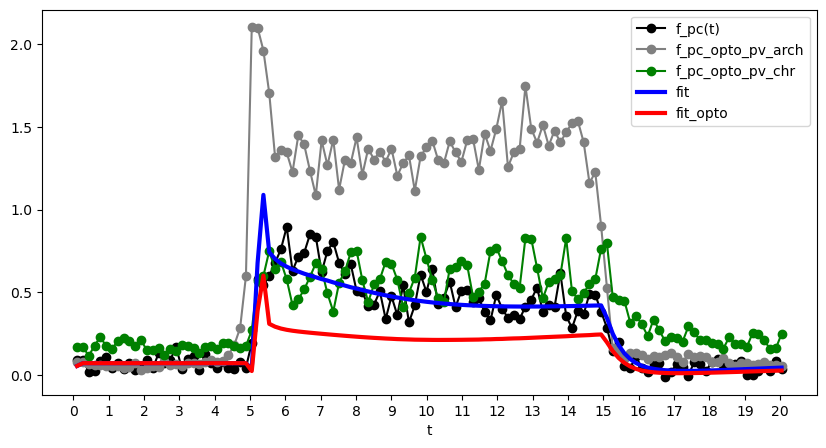

In [58]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
#plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
#plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_e_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
#plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [59]:
# print(model['f_e_o'].values)
# print(model['f_e'].values)
# for i,t in enumerate(t_exp):
#     print(t, data_sst[i])

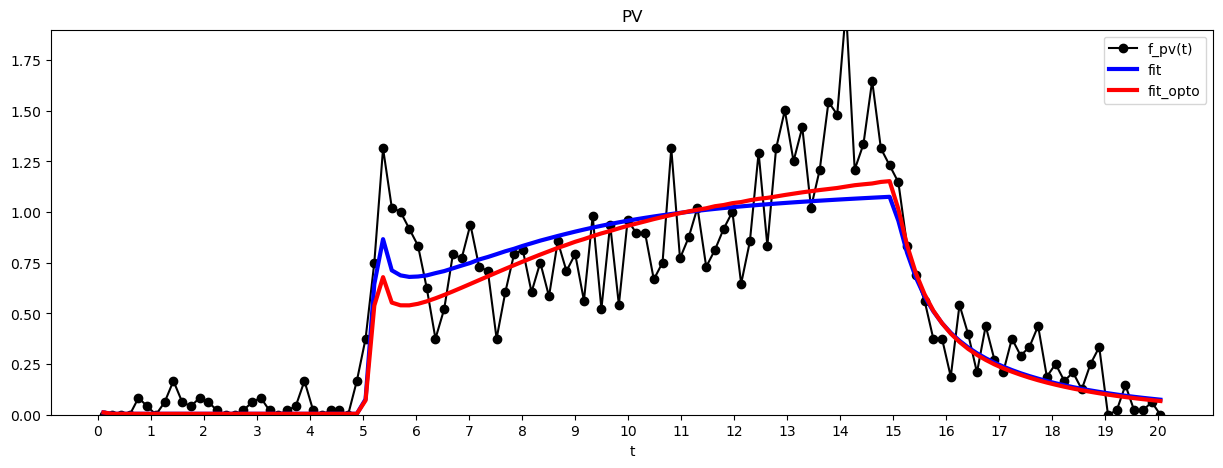

In [60]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.9)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [61]:
print(model['f_pv'].values)
print(model['f_pv_o'].values)
print(model['f_pv'].values/model['f_pv_o'].values)

[0.011      0.00451677 0.00451028 0.00451537 0.00451186 0.00451548
 0.00451983 0.00451079 0.00452306 0.00451221 0.00450723 0.00451811
 0.00450597 0.00451236 0.00451618 0.00451192 0.004518   0.00451205
 0.00451141 0.00451652 0.00450944 0.00451508 0.00451351 0.0045175
 0.00451722 0.00451125 0.00451725 0.0045093  0.00451179 0.0045196
 0.07684177 0.6450964  0.86652405 0.71249288 0.68769938 0.68012446
 0.68210052 0.68756141 0.69875881 0.70881121 0.72249221 0.73610702
 0.74919858 0.7660308  0.77841665 0.79237619 0.80665689 0.81895485
 0.83335427 0.84616408 0.85916974 0.87058907 0.88214261 0.89302699
 0.9036196  0.91370729 0.92334092 0.93250285 0.94120519 0.94946391
 0.9572902  0.96470002 0.97171238 0.97834573 0.98461861 0.99055105
 0.99616257 1.00147313 1.00650146 1.01126645 1.01578708 1.02007876
 1.02415976 1.02804437 1.03174872 1.03528577 1.03866873 1.04191043
 1.04502194 1.0480139  1.05089616 1.05367786 1.05636752 1.05897288
 1.06150119 1.06395916 1.06635274 1.0686875  1.07096863 1.073200

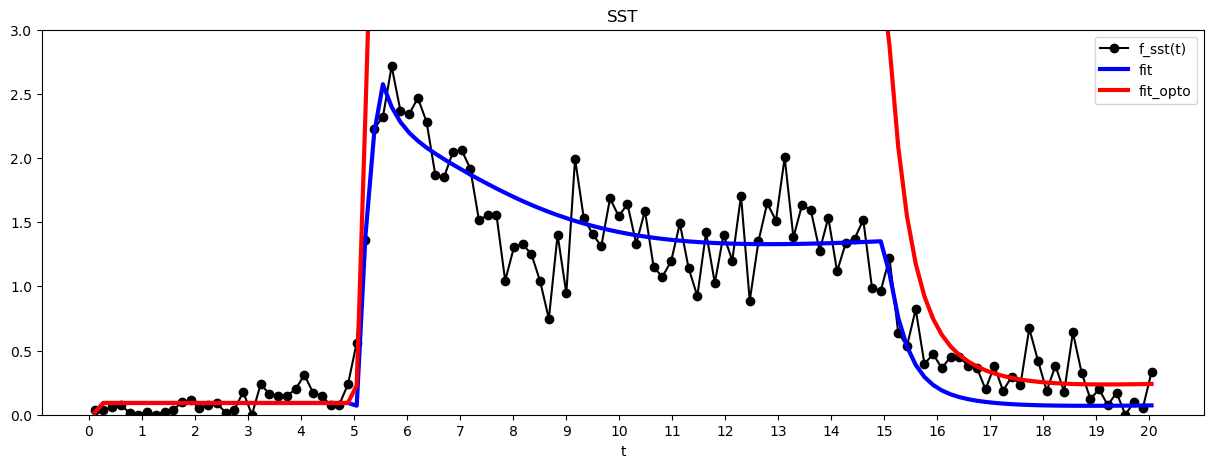

In [62]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 3.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [63]:
print(model['f_sst'].values)
print(model['f_sst_o'].values)
print(model['f_sst'].values/model['f_sst_o'].values)

[0.017      0.09155626 0.09155374 0.09155189 0.09155316 0.09155185
 0.09155027 0.09155355 0.0915491  0.09155303 0.09155484 0.09155089
 0.0915553  0.09155298 0.09155159 0.09155314 0.09155093 0.09155309
 0.09155332 0.09155147 0.09155404 0.09155199 0.09155256 0.09155112
 0.09155122 0.09155338 0.09155121 0.09155409 0.09155319 0.09155036
 0.07028275 1.39219834 2.19500889 2.57564432 2.39850896 2.28110829
 2.19770483 2.1343381  2.0808382  2.0346453  1.99111256 1.9499984
 1.91065076 1.87132255 1.83443875 1.79808222 1.76273702 1.72909887
 1.69612417 1.66487905 1.6349754  1.60692196 1.58030758 1.55532776
 1.53190988 1.51009556 1.48985006 1.47114339 1.45393013 1.43815717
 1.42376719 1.4106975  1.39888263 1.38825562 1.37874911 1.37029586
 1.36282977 1.35628628 1.35060318 1.34572052 1.34158089 1.33813032
 1.33531716 1.33309319 1.33141279 1.33023362 1.32951601 1.32922295
 1.3293202  1.32977601 1.33056096 1.33164791 1.3330118  1.33462955
 1.33647992 1.33854339 1.34080201 1.34323939 1.34584039 1.34859

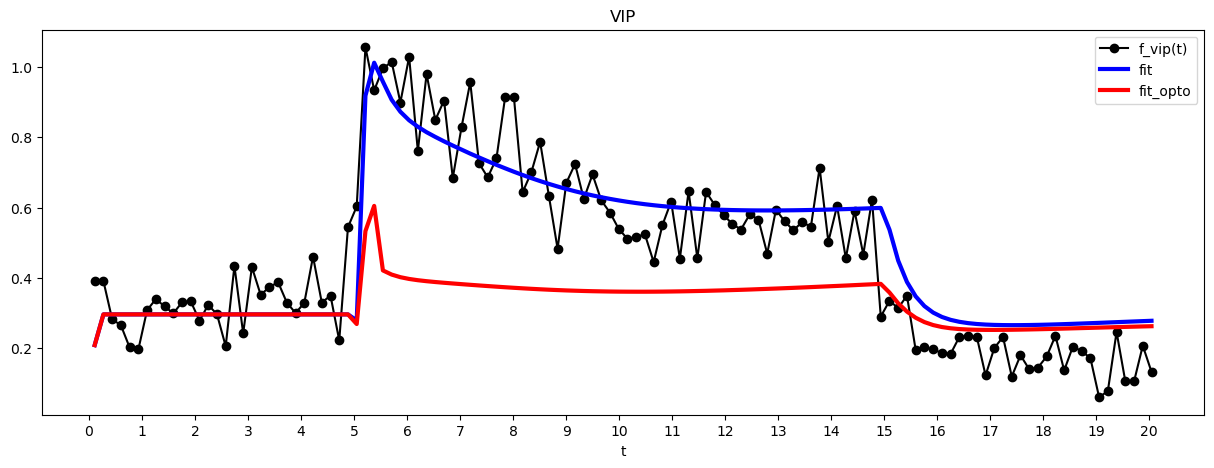

In [64]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [65]:
print(model['f_vip'].values)
print(model['f_vip_o'].values)

[0.208      0.2955732  0.29558438 0.29558295 0.29558394 0.29558292
 0.29558169 0.29558424 0.29558079 0.29558384 0.29558524 0.29558218
 0.2955856  0.2955838  0.29558272 0.29558392 0.29558221 0.29558388
 0.29558407 0.29558262 0.29558462 0.29558303 0.29558347 0.29558235
 0.29558243 0.29558411 0.29558242 0.29558466 0.29558396 0.29558176
 0.27842352 0.91825943 1.01235138 0.95838743 0.90685726 0.87269214
 0.84841492 0.82997533 0.81443294 0.80100363 0.78835004 0.77638065
 0.76490079 0.75341247 0.74259748 0.73191581 0.72150517 0.71156624
 0.70180476 0.6925287  0.68363023 0.67525936 0.66730125 0.65981539
 0.65278373 0.64622111 0.64011988 0.63447349 0.62927055 0.62449714
 0.62013778 0.61617512 0.61259076 0.60936559 0.60648018 0.60391496
 0.60165051 0.59966774 0.59794814 0.59647377 0.59522738 0.59419266
 0.59335396 0.59269662 0.59220672 0.59187132 0.59167825 0.59161614
 0.59167445 0.5918434  0.5921139  0.59247756 0.59292664 0.59345397
 0.59405297 0.59471759 0.59544226 0.59622188 0.59705175 0.5979

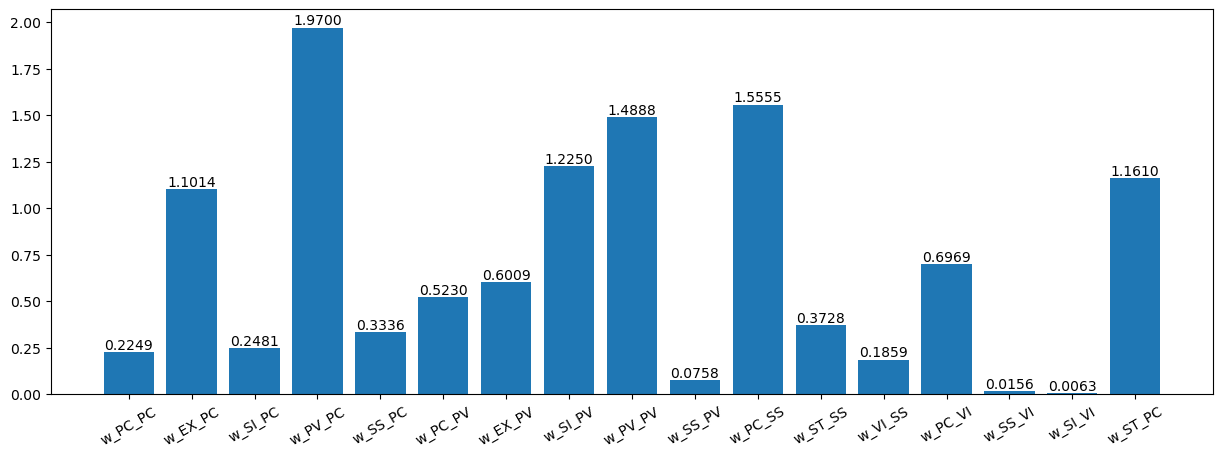

In [66]:
vals = []
for _, param in params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [67]:
# sig = []
# ex = []
# st = []
# for i in t_exp:
#     sig.append(Sigm(i, ampl = 1.01359931, rate = 1.75139660, delay = 1.45963700, decay_s = 0.29203316, base = 0))
#     ex.append(expon(i, ampl = ampl, base = 1, decay = 0.40151011, delay = 0.19882197, decay_ff = 1.39646321, exp_start = 0.00235982, decay_exp = 0.09660958))
#     st.append(Step(i, k = 0, delay = 0.41140712, decay_f = 0.5))
    
# plt.figure(figsize = (15,10))
# plt.plot(t_exp, np.array(sig), linewidth = 3)
# plt.plot(t_exp, np.array(ex), linewidth = 3)
# plt.plot(t_exp, np.array(st), linewidth = 3)
# #plt.plot(t_exp, 1.7*np.array(sig)+1.52*np.array(ex)+0.74*np.array(st), linewidth = 3)
# #plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, model['f_sst'].values, label='fit', linewidth=3)
# #plt.plot(t_exp, model['f_pv'].values, label='fit', linewidth=3)
# #plt.plot(t_exp, data_pc_all, label = 'pc', linewidth = 1)
# #plt.plot(t_exp, data_pv, label = 'pv', linewidth = 1)
# #plt.plot(t_exp, data_sst, label = 'sst', linewidth = 1)
# #plt.plot(t_exp, data_vip, label = 'vip', linewidth = 1)
# plt.legend()
# #plt.xlim(4.5, 6.5)
# plt.show()


# """
#  ampl_1:     1.01359931 (init = 1)
#     r_1:        1.75139660 (init = 1.638479)
#     delay_1:    0.21200599 (init = 0.2032416)
#     delay_2:    1.45963700 (init = 1.400737)
#     delay_3:    0.41140712 (init = 0.363557)
#     decay:      3.51342590 (init = 3.702939)
#     decay_s:    0.29203316 (init = 0.3060473)
#     decay_f:    0.5 (fixed)
#     decay_ff:   1.39646321 (init = 0.5)
#     ampl:       1.05399785 (init = 1.093407)
#     base:       1 (fixed)
#     base_sigm:  0 (fixed)
# """

In [68]:
# inp = pd.DataFrame()
# inp['t'] = t_exp
# inp['FF'] = ex
# inp['SM'] = sig
# inp['FB'] = st
# inp

In [69]:
# inp[['t', 'FF', 'SM', 'FB']].to_csv('out_inputs.csv', index=False)

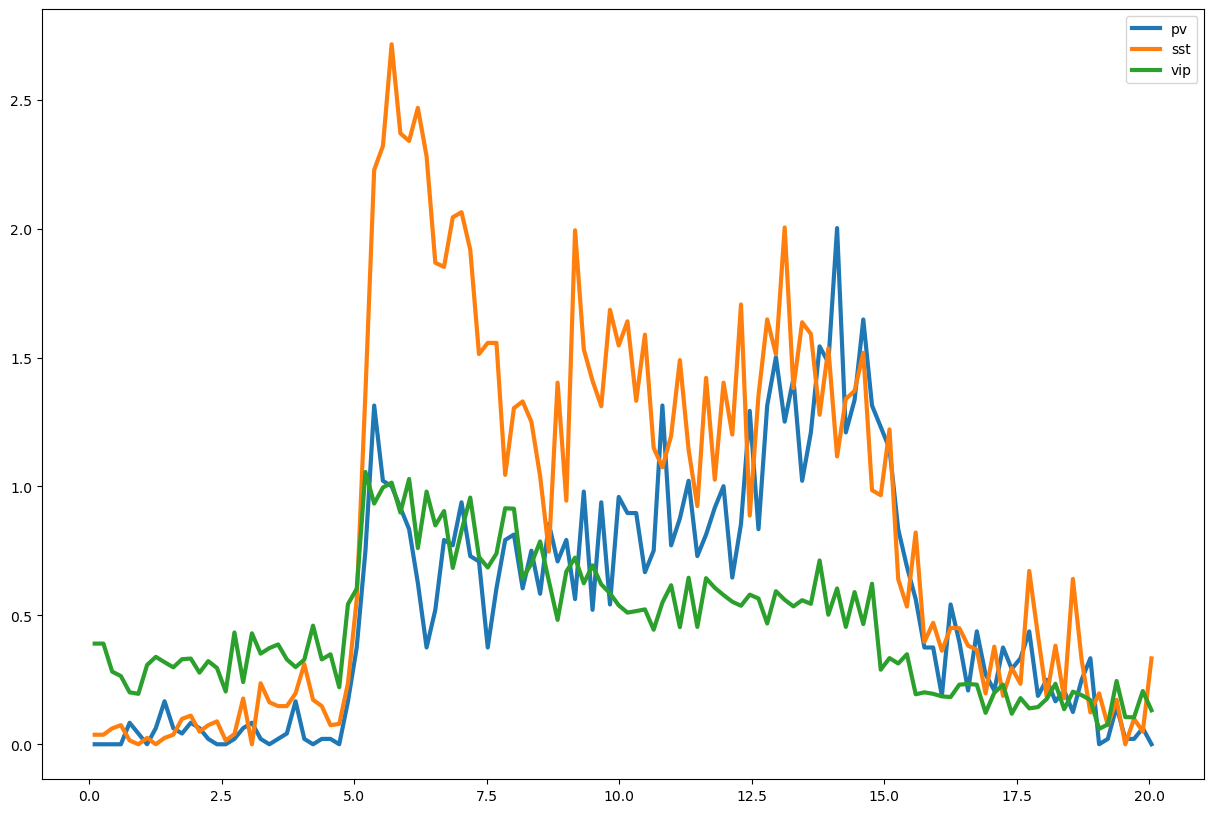

In [70]:
plt.figure(figsize = (15,10))
# plt.plot(t_exp, np.array(sig)*1.4 +0.4)
# plt.plot(t_exp, np.array(ex))
# plt.plot(t_exp, np.array(st))
#plt.plot(t_exp, data_pc_sen, label = 'pc', linewidth = 3)
plt.plot(t_exp, data_pv, label = 'pv', linewidth = 3)
plt.plot(t_exp, data_sst, label = 'sst', linewidth = 3)
plt.plot(t_exp, data_vip, label = 'vip', linewidth = 3)
plt.legend()
#plt.xlim(4.5, 5.5)
plt.show()

In [71]:
# for i in t_exp:
#     print(i, expon(i, ampl = 0.5, base = 1.05259920, decay = 5.12622052, delay = 0.54586319))

# Solve

## leastsq (Levenberg-Marquardt)

In [69]:
count = 0

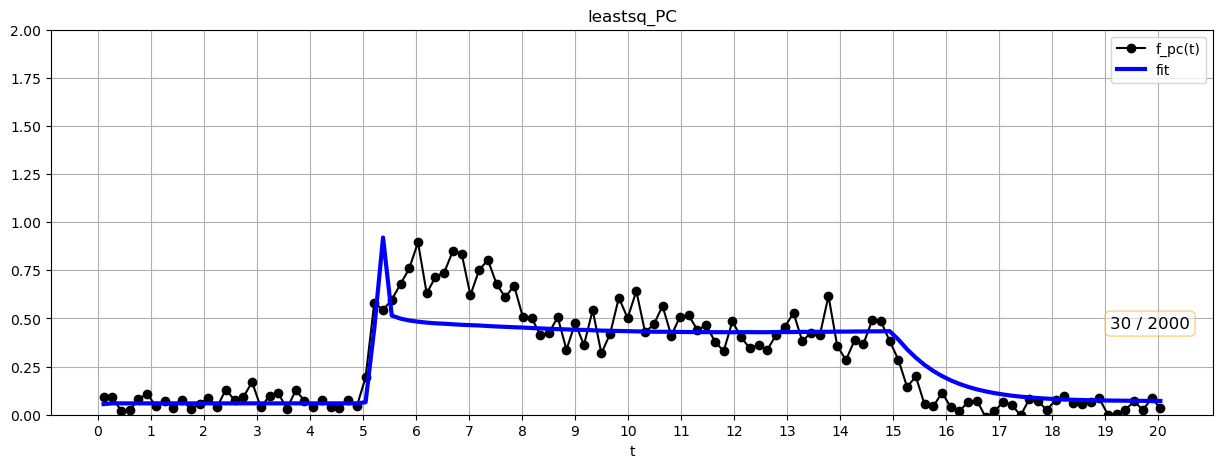


CPU times: total: 34.5 s
Wall time: 35.2 s


In [70]:
%%time
%matplotlib inline

result_leastsq = minimize(residual_step, params, method='least_squares', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=30, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [71]:
report_fit(result_leastsq)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 488
    # variables        = 23
    chi-square         = 42.3025344
    reduced chi-square = 0.09097319
    Akaike info crit   = -1147.38858
    Bayesian info crit = -1051.01133
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.13472192 (init = 0.1656221)
    w_1:        0.77083927 (init = 0.7598499)
    w_2:        0.45987319 (init = 0.533095)
    w_3:        2.11906703 (init = 1.955607)
    w_4:        0.65256986 (init = 0.631901)
    w_5:        0.45983468 (init = 0.4144784)
    w_6:        0.45187794 (init = 0.4631842)
    w_7:        1.04359301 (init = 1.055847)
    w_8:        1.52648833 (init = 1.510296)
    w_9:        0.24518907 (init = 0.2501333)
    w_10:       1.60353896 (init = 1.567415)
    w_11:       0.57076670 (init = 0.5941593)
    w_12:       0.16020063 (init = 0.1499703)
    w_13:       0.68994793 (init = 0.6479797)
    w_14

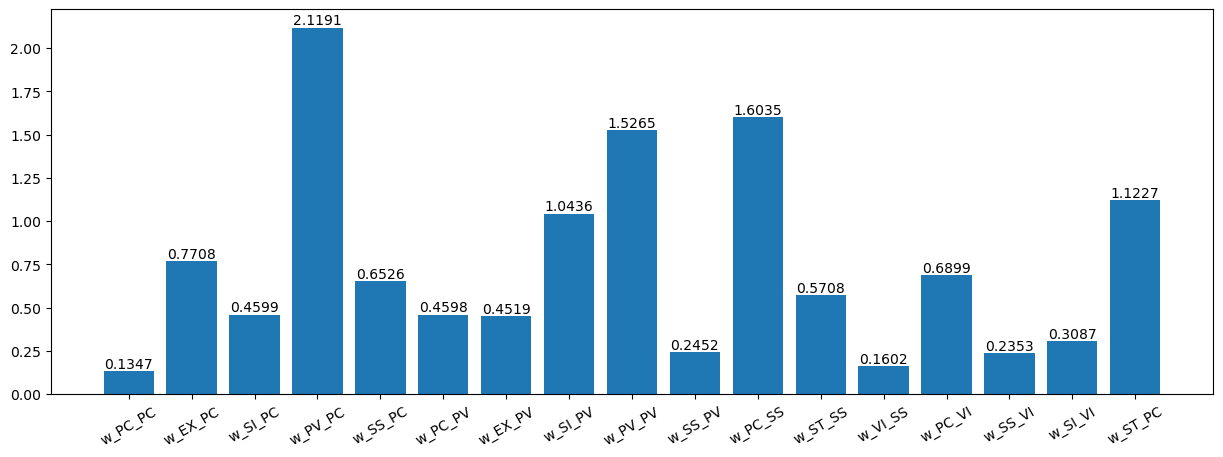

In [72]:
vals = []
for _, param in result_leastsq.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

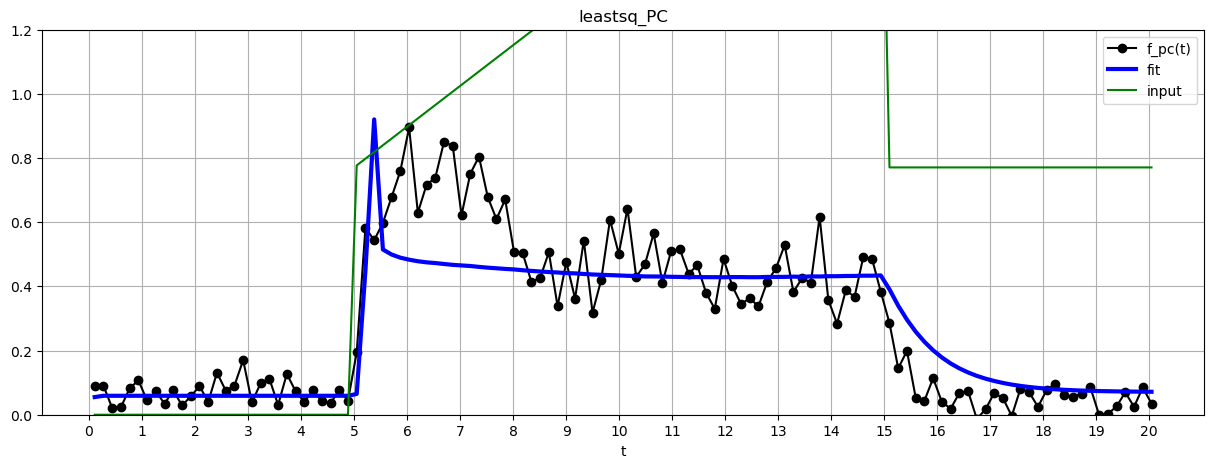

In [73]:
sim_leastsq = simulate_step(t_exp, init, params)
fit_leastsq = simulate_step(t_exp, init, result_leastsq.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsq.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsq['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

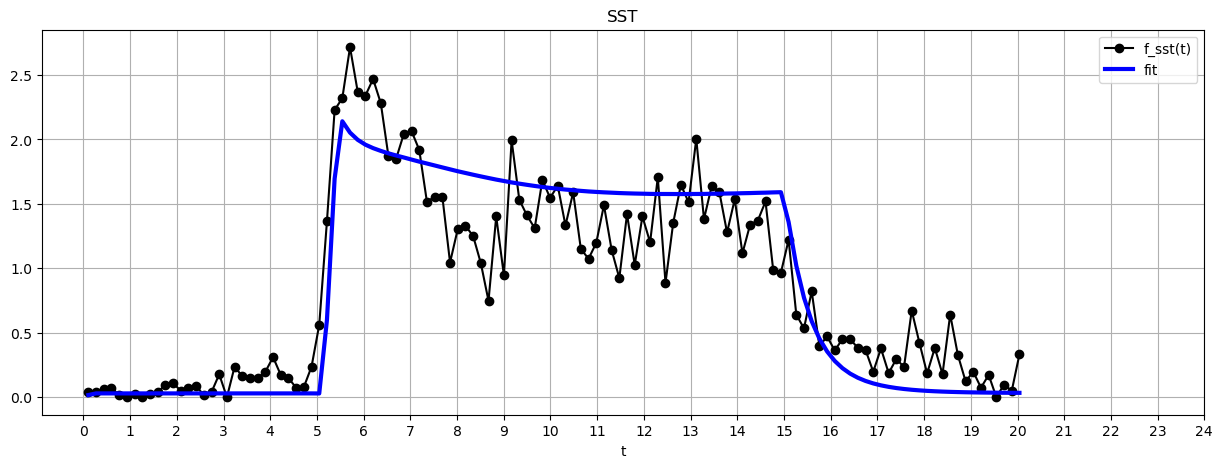

In [74]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsq['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

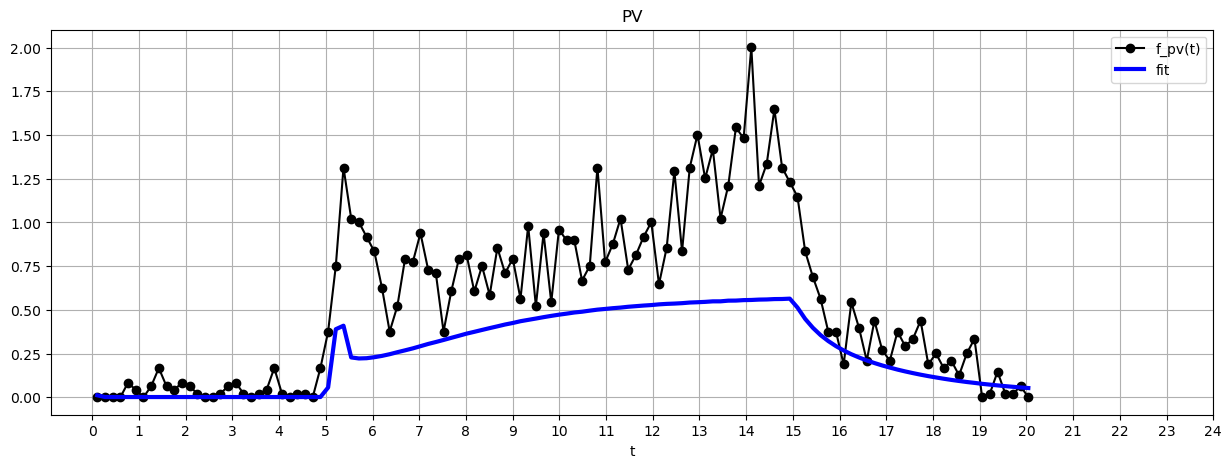

In [75]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsq['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

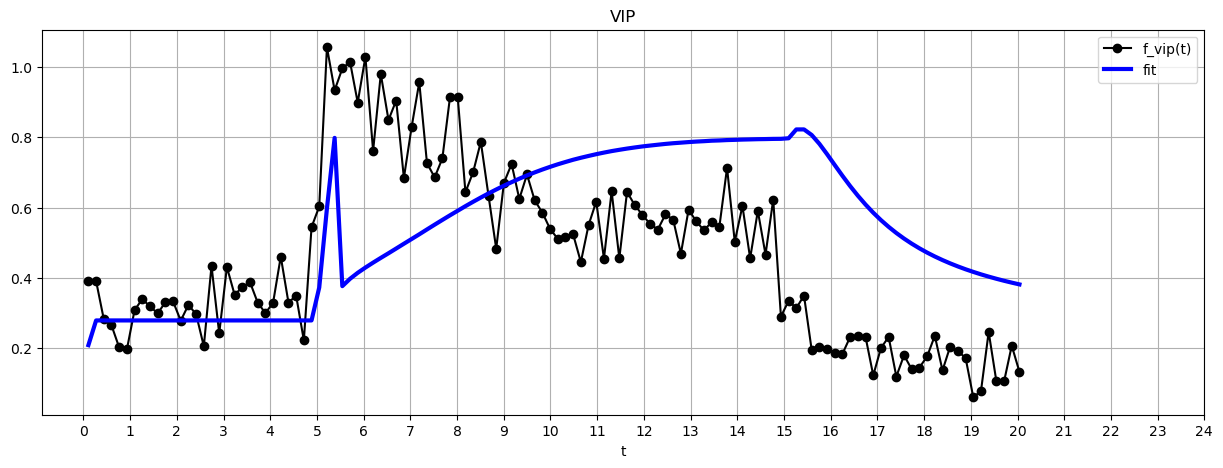

In [76]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsq['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

## least_squares

In [77]:
count = 0

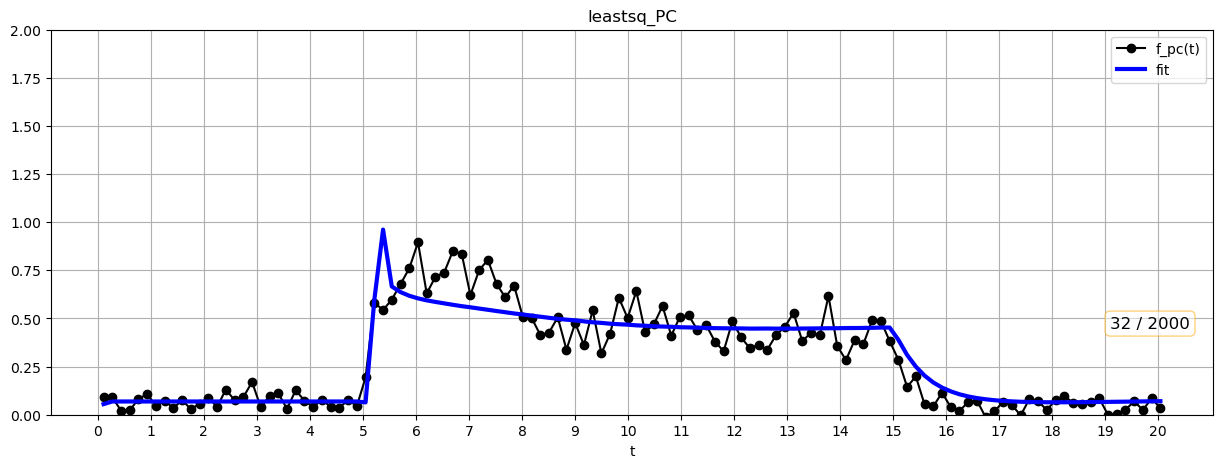


CPU times: total: 39 s
Wall time: 39.7 s


In [78]:
%%time
%matplotlib inline

result_leastsqs = minimize(residual_step, params, method='leastsq', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=30, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [79]:
report_fit(result_leastsqs)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 488
    # variables        = 23
    chi-square         = 33.7158847
    reduced chi-square = 0.07250728
    Akaike info crit   = -1258.10501
    Bayesian info crit = -1161.72775
##  Warning: uncertainties could not be estimated:
    i_2:        at initial value
[[Variables]]
    w_0:        0.18460340 (init = 0.1656221)
    w_1:        0.93542443 (init = 0.7598499)
    w_2:        0.48093157 (init = 0.533095)
    w_3:        2.49518599 (init = 1.955607)
    w_4:        0.56710495 (init = 0.631901)
    w_5:        0.51198431 (init = 0.4144784)
    w_6:        0.46022591 (init = 0.4631842)
    w_7:        1.06945801 (init = 1.055847)
    w_8:        1.51343154 (init = 1.510296)
    w_9:        0.25002006 (init = 0.2501333)
    w_10:       1.31579993 (init = 1.567415)
    w_11:       0.50065515 (init = 0.5941593)
    w_12:       0.12410078 (init = 0.1499703)
    w_13:       0.37909500 

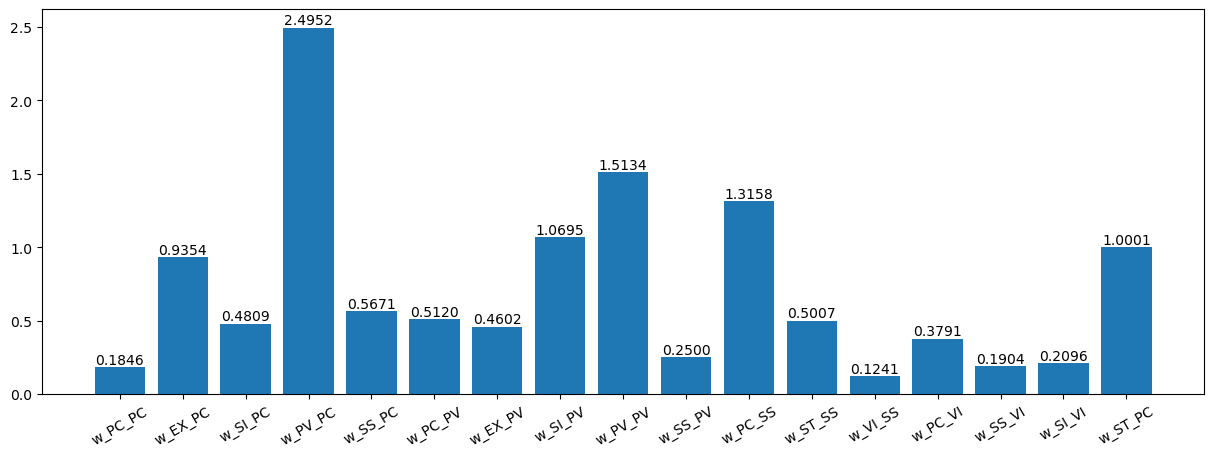

In [80]:
vals = []
for _, param in result_leastsqs.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

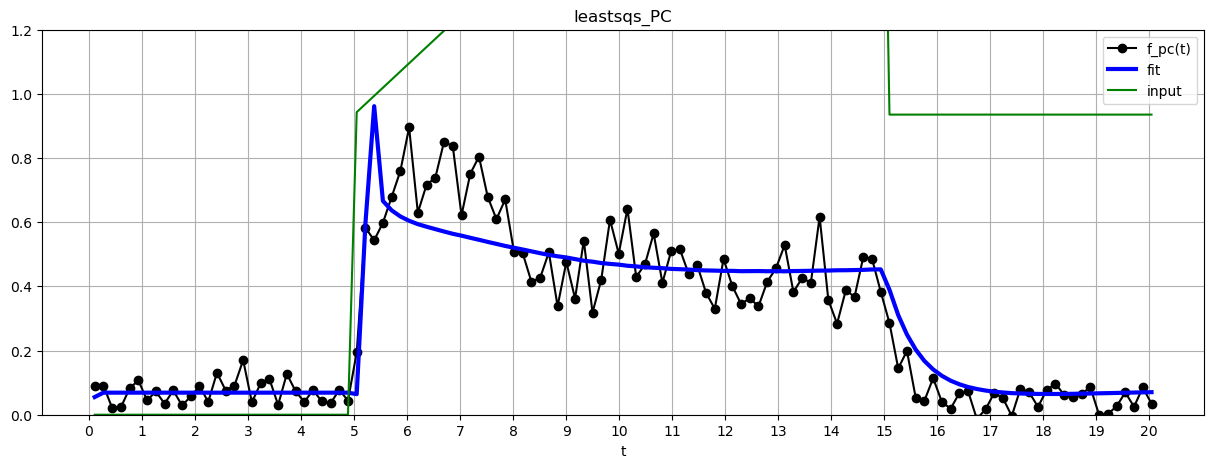

In [81]:
sim_leastsqs = simulate_step(t_exp, init, params)
fit_leastsqs = simulate_step(t_exp, init, result_leastsqs.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsqs.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsqs['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsqs_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

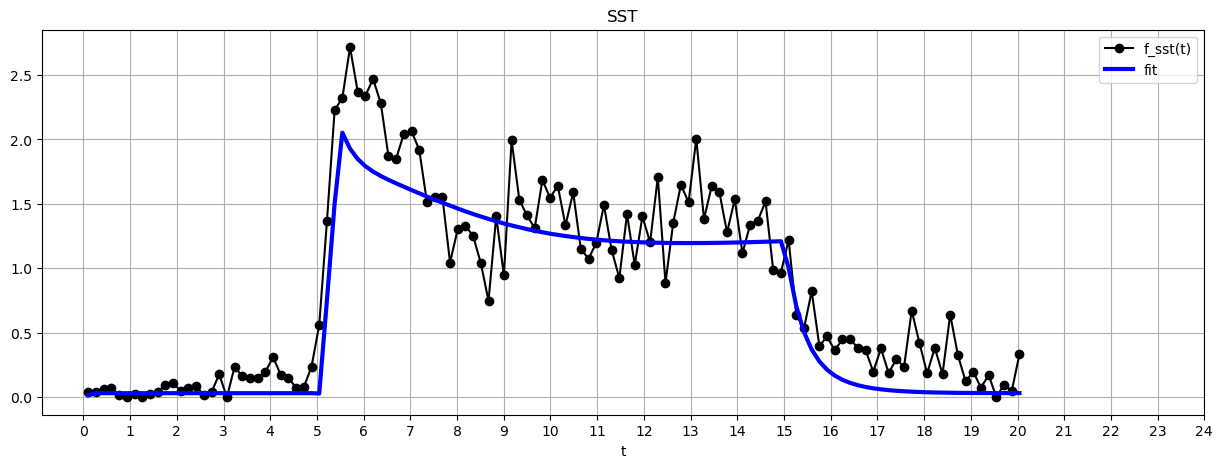

In [82]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsqs['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

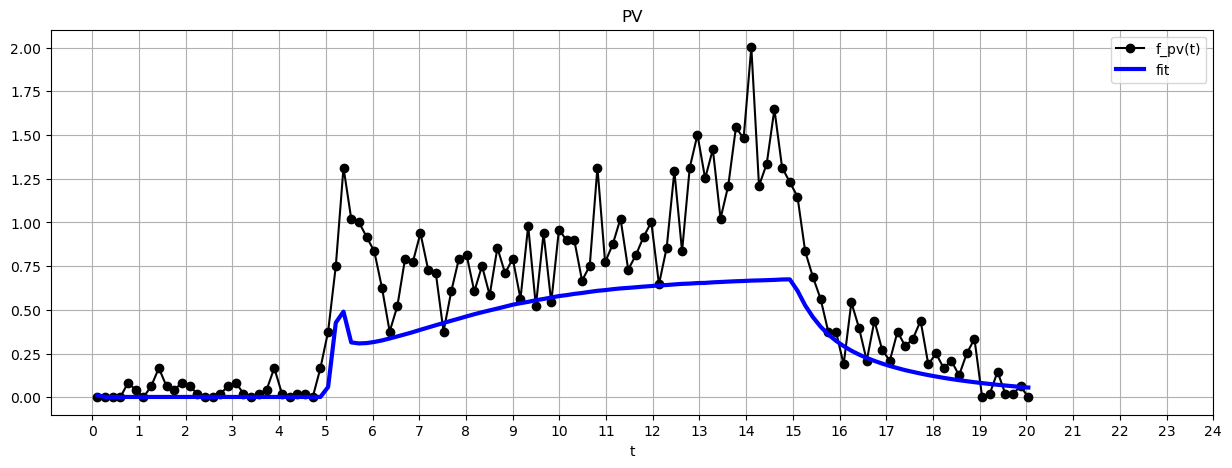

In [83]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsqs['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

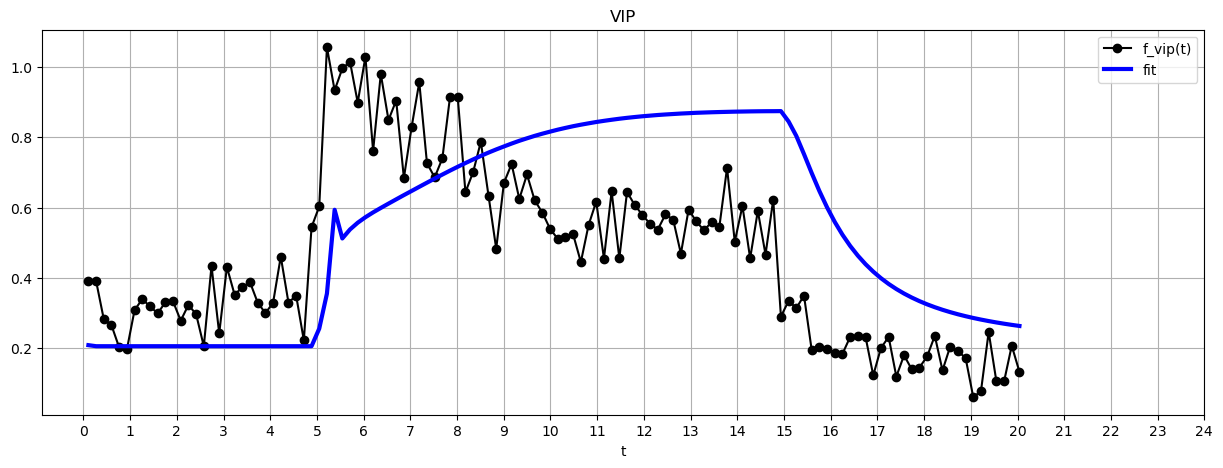

In [84]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsqs['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

## nelder

In [85]:
count = 0

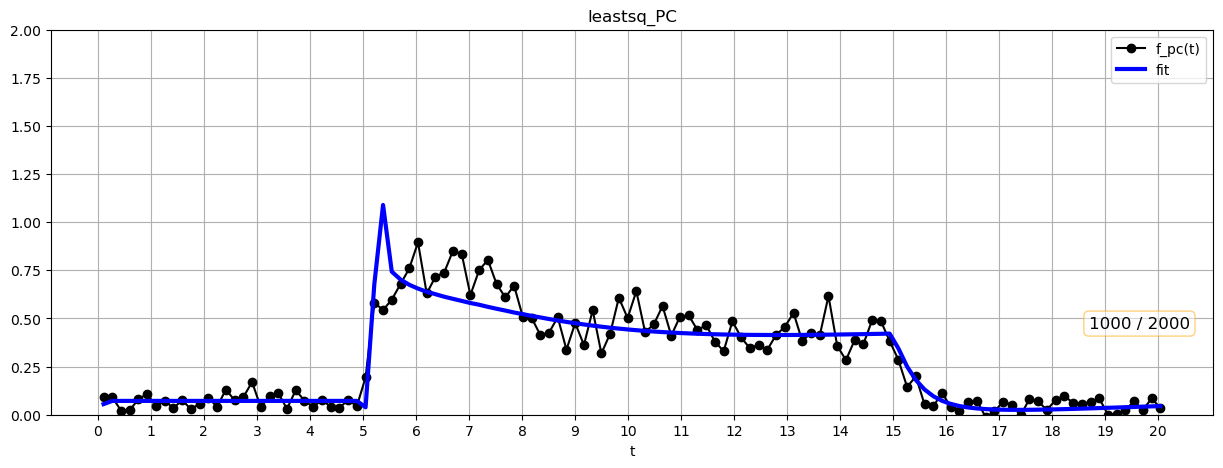


CPU times: total: 21min 59s
Wall time: 22min 4s


In [86]:
%%time

%matplotlib inline

result_nelder = minimize(residual_step, params, method='nelder', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', options = {'adaptive' : True}, max_nfev = 1000)
print()


In [87]:
report_fit(result_nelder)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1001
    # data points      = 488
    # variables        = 23
    chi-square         = 14.7952862
    reduced chi-square = 0.03181782
    Akaike info crit   = -1660.05131
    Bayesian info crit = -1563.67405
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.22494800 (init = 0.1656221)
    w_1:        1.10143194 (init = 0.7598499)
    w_2:        0.24810577 (init = 0.533095)
    w_3:        1.97002258 (init = 1.955607)
    w_4:        0.33357873 (init = 0.631901)
    w_5:        0.52302201 (init = 0.4144784)
    w_6:        0.60092909 (init = 0.4631842)
    w_7:        1.22499424 (init = 1.055847)
    w_8:        1.48880306 (init = 1.510296)
    w_9:        0.07577982 (init = 0.2501333)
    w_10:       1.55551425 (init = 1.567415)
    w_11:       0.37281284 (init = 0.5941593)
    w_12:       0.18591899 (init = 0.1499703)
    w_13:       0.69694172 (init = 0.6479797)
    w_14

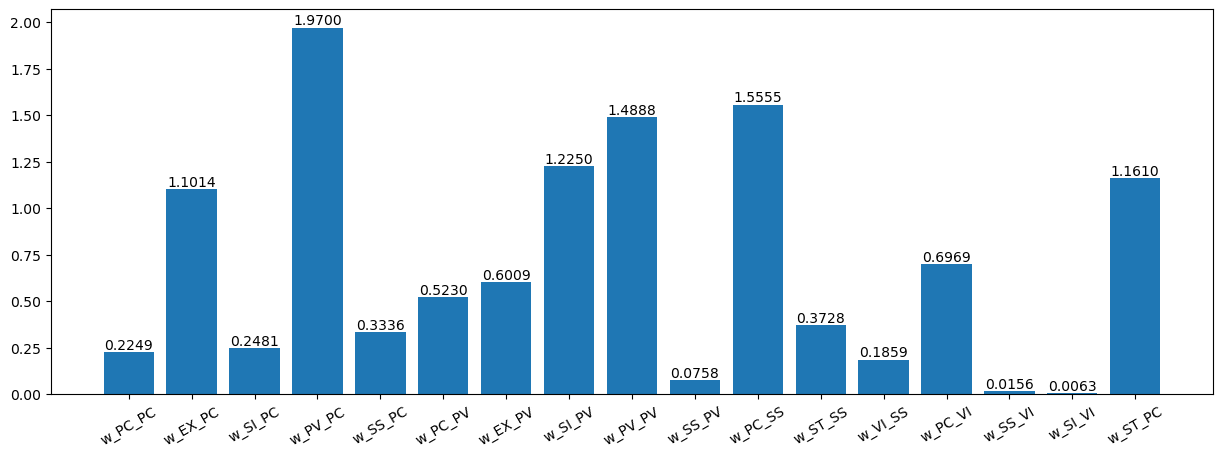

In [88]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

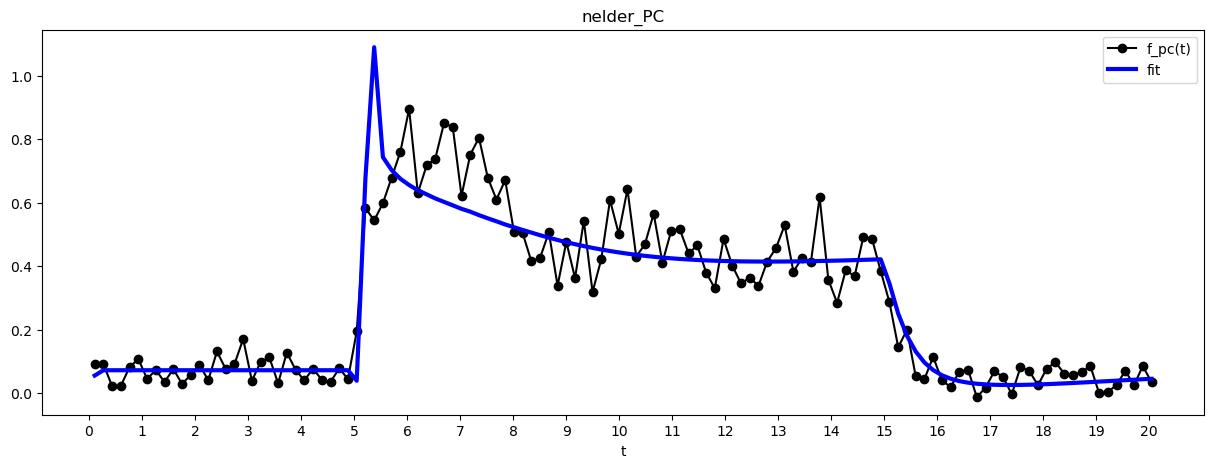

In [89]:
sim_nelder = simulate_step(t_exp, init, params)
fit_nelder = simulate_step(t_exp, init, result_nelder.params)
step_pv = []
#step_sst = []
# step = []

# for i in t_exp:
#     #step_sst.append(f_s(i, data_sst_exc))
#     step.append(Step(i, amp = 0.5, base = 0.0))
    
# curve =np.array(step) * result_nelder.params['w_2'].value

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_nelder['f_e'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('nelder_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 5)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

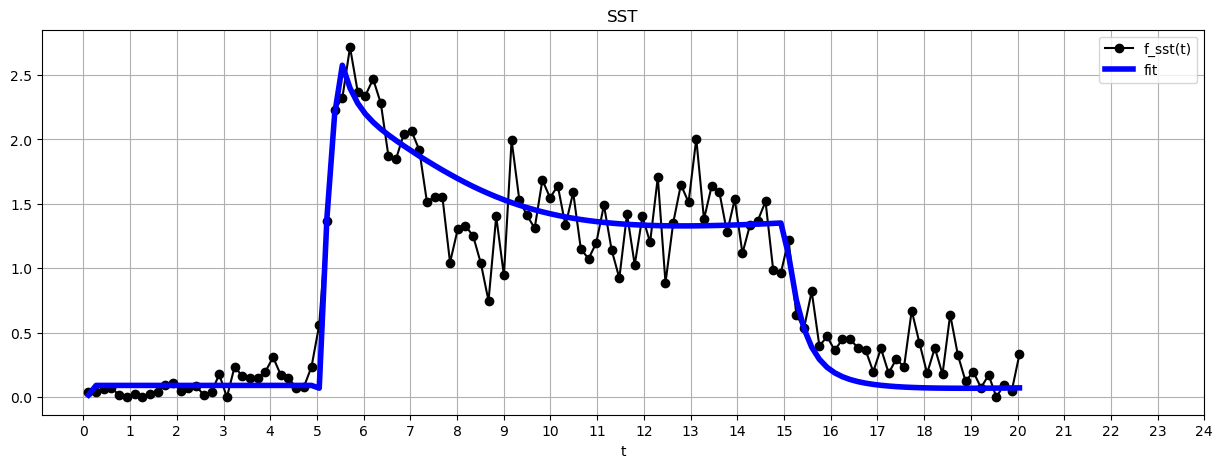

In [90]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_nelder['f_sst'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.ylim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

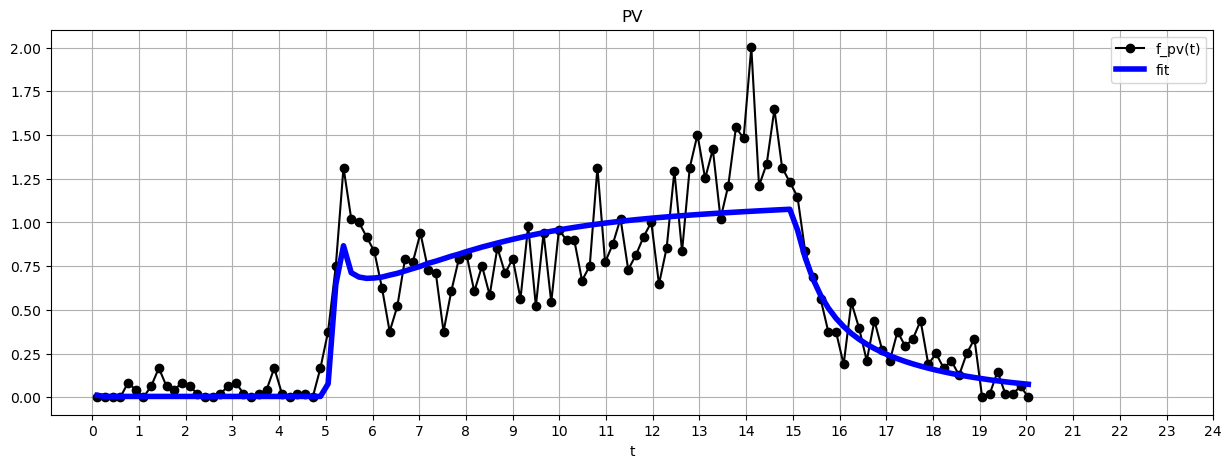

In [91]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_nelder['f_pv'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

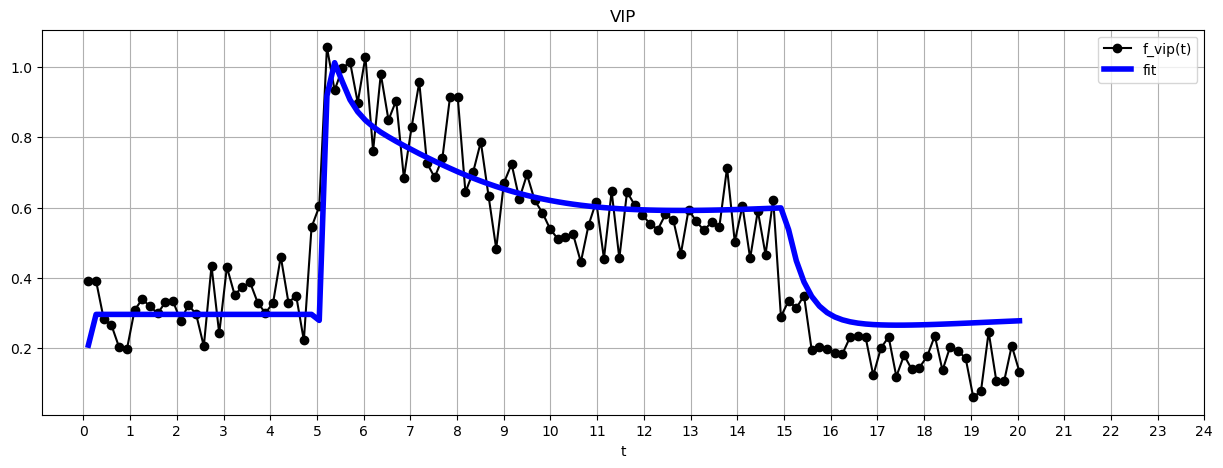

In [92]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_nelder['f_vip'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [133]:
model_opto = simulate_step(t_exp, init, result_nelder.params)

In [134]:
model_opto[['t', 'f_e', 'f_pv', 'f_sst', 'f_vip']].to_csv('traces_s1_hab_NoLoco_27_03_2025.csv', index=False)

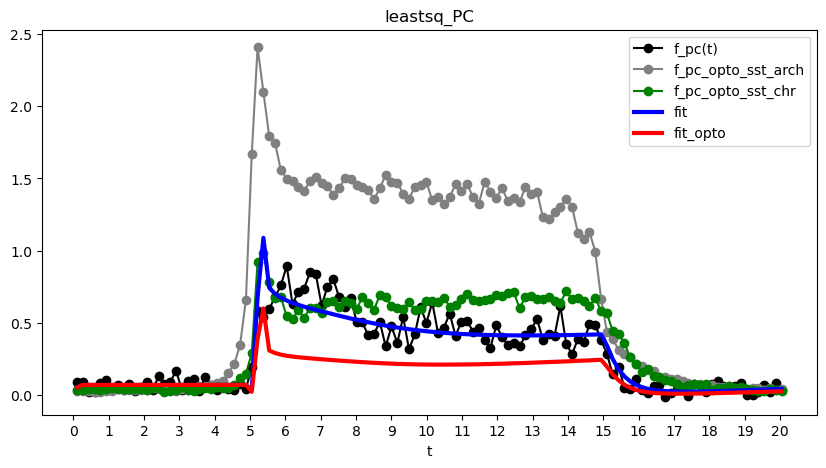

In [94]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
#plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model_opto['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

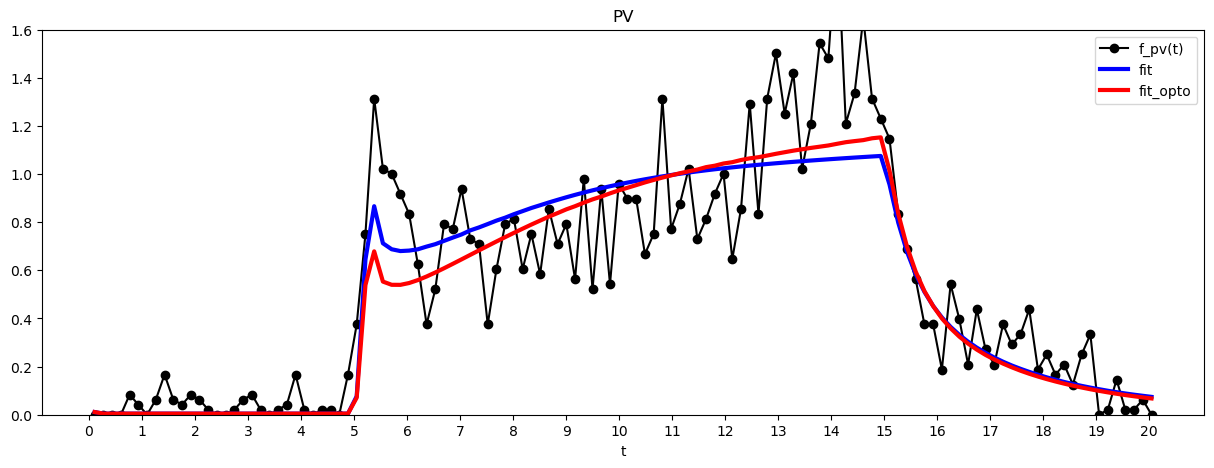

In [95]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

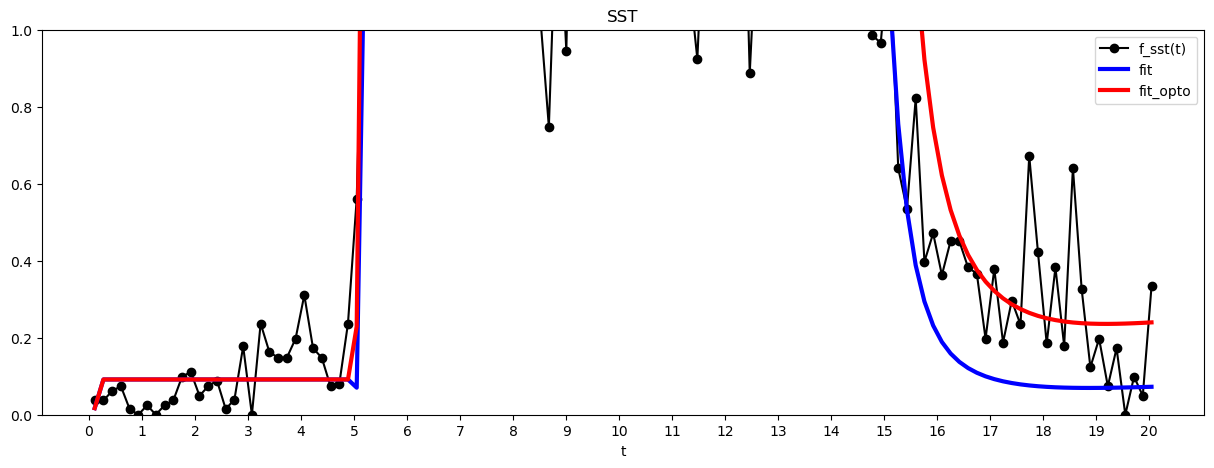

In [96]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

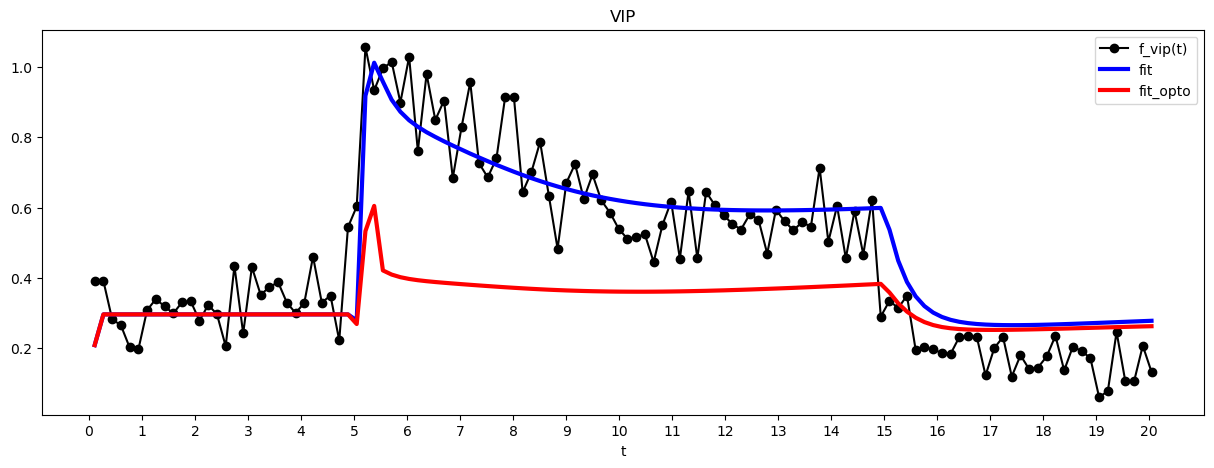

In [97]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

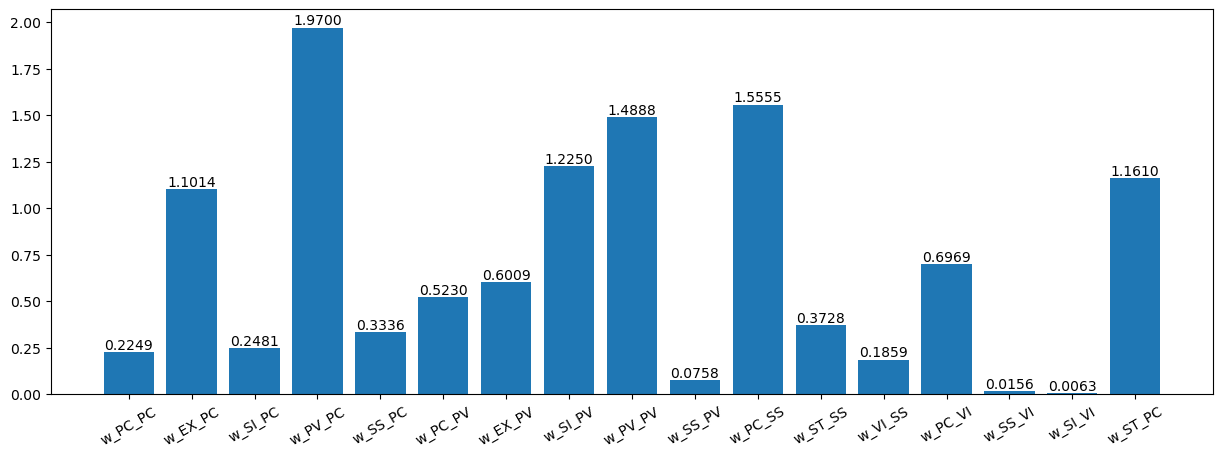

In [98]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [99]:
heat = pd.DataFrame()
heat[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
heat['PC'] = [0.01222982, 2.25251760, 2.70988047, None, 0.97270781, 1.53293469, 1.32938450]
heat['PV'] = [0.66931084, 1.39211370, 1.14684455, None, 0.22043244, 1.90878325, None]
heat['SST'] = [0.17210378, None, None, 0.15543846, None, None, 0.65516905]
heat['VIP'] = [0.04639222, None, 0.00206863, None, None, 0.79944357, None]
heat.set_index('', inplace = True)

In [132]:
heat_new_ = pd.DataFrame()
heat_new_[''] = ['PC', 'SST', 'PV', 'VIP_P', 'VIP_N']

heat_new_['PC'] = [result_nelder.params["w_0"].value,
                  result_nelder.params["w_10"].value,
                  result_nelder.params["w_5"].value,
                  result_nelder.params["w_13"].value,
                  None]

heat_new_['SST'] = [result_nelder.params["w_4"].value,
                  None,
                  result_nelder.params["w_9"].value,
                  result_nelder.params["w_14"].value,
                  None]

heat_new_['PV'] = [result_nelder.params["w_3"].value,
                   None,
                   result_nelder.params["w_8"].value,
                   None,
                   None]

heat_new_['VIP_P'] = [None,
                   result_nelder.params["w_12"].value,
                   None,
                   None,
                   None]

heat_new_['VIP_N'] = [None,
                   None,
                   None,
                   None,
                   None]

heat_new_['FF'] = [result_nelder.params["w_1"].value,
                   None,
                   result_nelder.params["w_6"].value,
                   None,
                   None]

heat_new_['SM'] = [result_nelder.params["w_2"].value,
                   None,
                   result_nelder.params["w_7"].value,
                   result_nelder.params["w_15"].value,
                   None]

heat_new_['FB'] = [result_nelder.params["w_16"].value,
                   result_nelder.params["w_11"].value,
                   result_nelder.params["w_17"].value,
                   result_nelder.params["w_18"].value,
                   None]

heat_new_.set_index('', inplace = True)

heat_new_.to_csv("heatmap_s1_hab_NoLoco_27_03_2025.csv.csv")

In [101]:
heat_new_ = heat_new_.map(lambda x: np.nan if x is None else x)

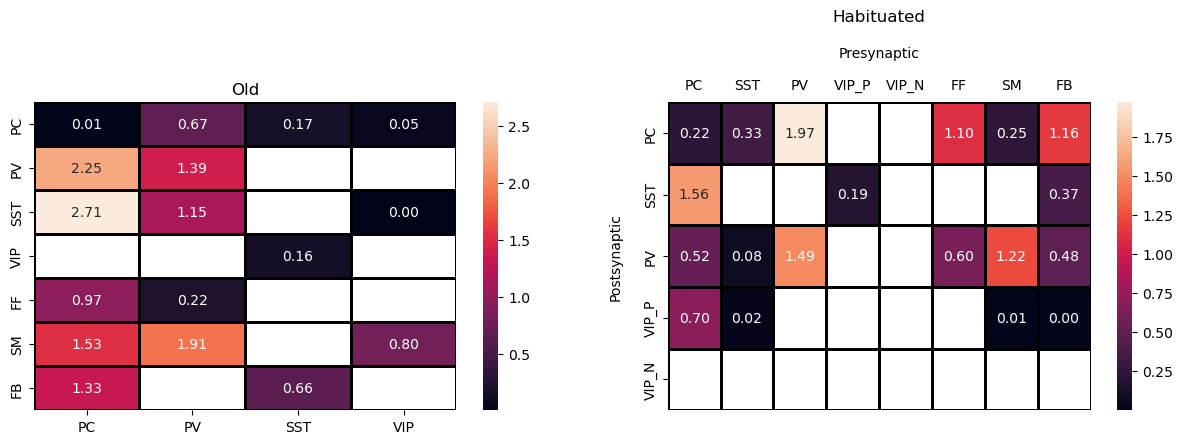

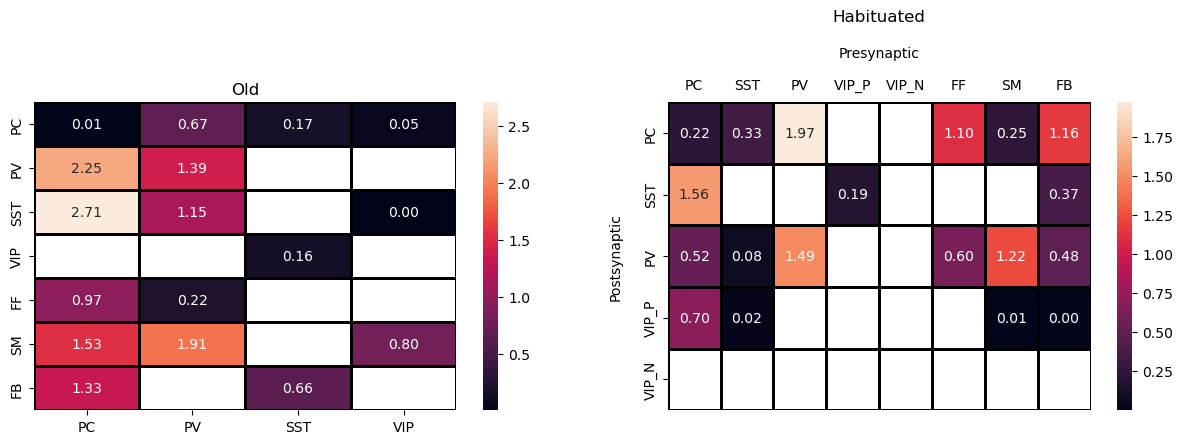

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".2f")
sns.heatmap(heat_new_, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".2f")
ax[0].set_title("Old")
ax[1].set_title("New")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("Habituated")
ax[1].xaxis.set_label_position("top")
display.display(fig)

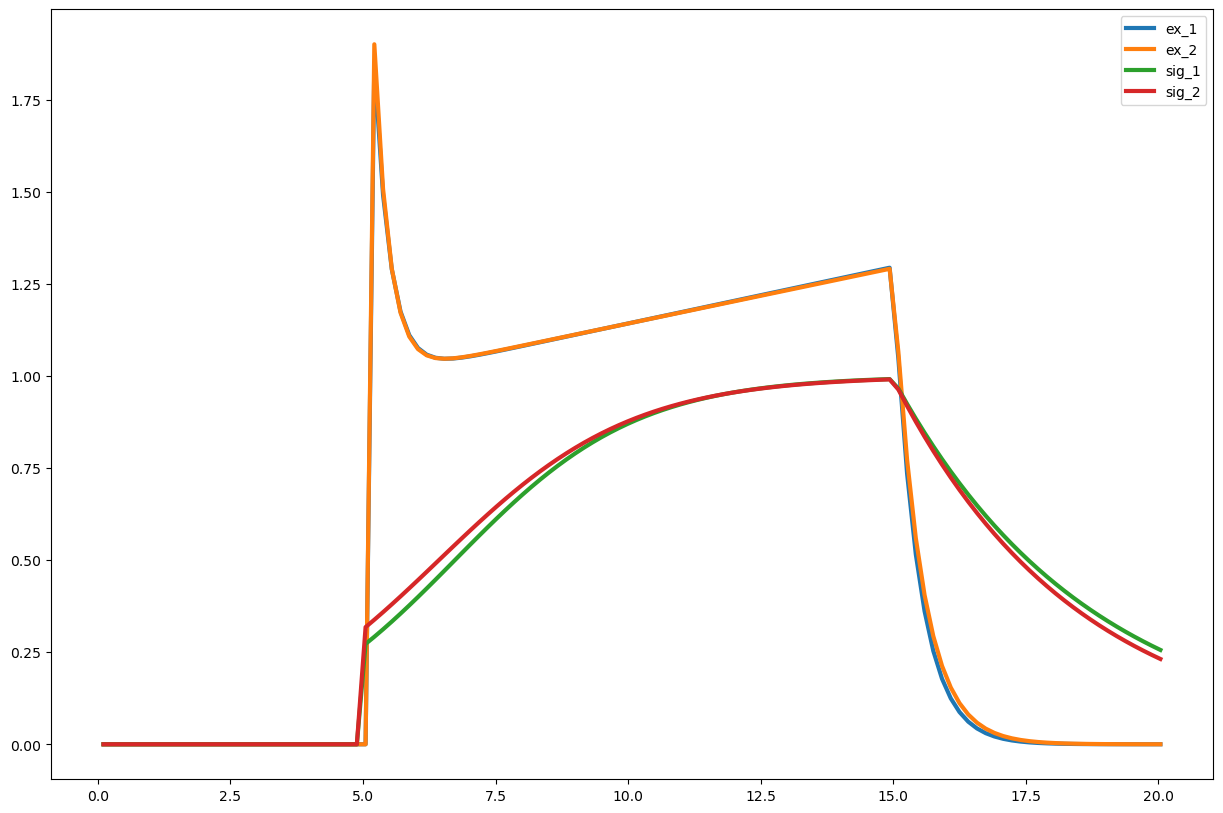

'\n ampl_1:     1.01359931 (init = 1)\n    r_1:        1.75139660 (init = 1.638479)\n    delay_1:    0.21200599 (init = 0.2032416)\n    delay_2:    1.45963700 (init = 1.400737)\n    delay_3:    0.41140712 (init = 0.363557)\n    decay:      3.51342590 (init = 3.702939)\n    decay_s:    0.29203316 (init = 0.3060473)\n    decay_f:    0.5 (fixed)\n    decay_ff:   1.39646321 (init = 0.5)\n    ampl:       1.05399785 (init = 1.093407)\n    base:       1 (fixed)\n    base_sigm:  0 (fixed)\n    expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, exp_start = exp_start, decay_exp = decay_exp)\n     Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)\n'

In [76]:
sig_1 = []
ex_1 = []
ex_2 = []
sig_2 = []
fb = []
for i in t_exp:
    sig_1.append(Sigm(i, ampl = 1, rate = 1.713939, delay = 1.73305, decay_s = 0.2685497, base = 0))
    sig_2.append(Sigm(i, ampl = 1, rate = 1.813819, delay = 1.432155, decay_s = 0.2883653, base = 0))
    ex_1.append(expon(i, ampl = 1, base = 1, decay = 3.324089, delay = 0.1650418, decay_ff = 2.152722, s_start = 0.1835884, k = 0.03068755))
    ex_2.append(expon(i, ampl = 1, base = 1, decay = 3.513848, delay = 0.1845045, decay_ff = 1.955969, s_start = 0.08071663, k = 0.03011387))
    fb.append(Step(i, k = 0, delay = 0.3695274, decay_f = 0.8342502))
    #st.append(Step(i, k = 0, delay = 0.41140712, decay_f = 0.5))
    
plt.figure(figsize = (15,10))
#plt.plot(t_exp, np.array(sig), linewidth = 3)
plt.plot(t_exp, np.array(ex_1), linewidth = 3, label = "ex_1")
plt.plot(t_exp, np.array(ex_2), linewidth = 3, label = "ex_2")
plt.plot(t_exp, np.array(sig_1), linewidth = 3, label="sig_1")
plt.plot(t_exp, np.array(sig_2), linewidth = 3, label="sig_2")
#plt.plot(t_exp, np.array(st), linewidth = 3)
#plt.plot(t_exp, 1.7*np.array(sig)+1.52*np.array(ex)+0.74*np.array(st), linewidth = 3)
#plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, model['f_sst'].values, label='fit', linewidth=3)
#plt.plot(t_exp, model['f_pv'].values, label='fit', linewidth=3)
#plt.plot(t_exp, data_pc_all, label = 'pc', linewidth = 1)
#plt.plot(t_exp, data_pv, label = 'pv', linewidth = 1)
#plt.plot(t_exp, data_sst, label = 'sst', linewidth = 1)
#plt.plot(t_exp, data_vip, label = 'vip', linewidth = 1)
plt.legend()
#plt.xlim(4.5, 6.5)
plt.show()


"""
 ampl_1:     1.01359931 (init = 1)
    r_1:        1.75139660 (init = 1.638479)
    delay_1:    0.21200599 (init = 0.2032416)
    delay_2:    1.45963700 (init = 1.400737)
    delay_3:    0.41140712 (init = 0.363557)
    decay:      3.51342590 (init = 3.702939)
    decay_s:    0.29203316 (init = 0.3060473)
    decay_f:    0.5 (fixed)
    decay_ff:   1.39646321 (init = 0.5)
    ampl:       1.05399785 (init = 1.093407)
    base:       1 (fixed)
    base_sigm:  0 (fixed)
    expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, exp_start = exp_start, decay_exp = decay_exp)
     Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)
"""

In [78]:
print("SM: ", np.array(sig_1).mean())
print("FF: ", np.array(ex_1).mean())
print("FB: ", np.array(fb).mean())

SM:  0.5233342241920398
FF:  0.6084239209553407
FB:  0.5415537122704709


## L-BFGS-B

In [104]:
# count = 0

In [105]:
# %%time
# %matplotlib inline
# result_lbfgsb = minimize(residual_step, params, method='lbfgsb', args=(t_exp, init, data_pc_sen, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=max_nfev/4, tol=1e-12)
# print()

In [106]:
# report_fit(result_lbfgsb)

In [107]:
# sim_lbfgsb = simulate_step(t_exp, init, params)
# fit_lbfgsb = simulate_step(t_exp, init, result_lbfgsb.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_lbfgsb.params['w_1'].value

# plt.figure(figsize=(10,5))
# plt.axis('auto')
# plt.plot(t_exp, pc_sen_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_lbfgsb['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_lbfgsb['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = (51/255, 255/255, 51/255), label='input')
# plt.title('PC_sen with "PV plasticity" + subpopulations', fontsize = 18)
# plt.legend(loc='upper left')
# plt.xlabel('time, s', fontsize=18)
# plt.ylabel('Firing rate, Hz', fontsize=18)
# plt.ylim(0, 0.6)
# plt.xticks(np.arange(0,21,1), size = 14)
# plt.yticks(size = 14)
# #plt.grid()

# # pars = (f"PC_sen:   {result_lbfgsb.params['w_0'].value:.6f} +/- {result_lbfgsb.params['w_0'].stderr:.6f}\n"
# #         f"PC_na:     {result_lbfgsb.params['w_1'].value:.6f} +/- {result_lbfgsb.params['w_1'].stderr:.6f}\n"
# #         f"PC_dep:   {result_lbfgsb.params['w_2'].value:.6f} +/- {result_lbfgsb.params['w_2'].stderr:.6f}\n"
# #         f"Input:      {result_lbfgsb.params['w_3'].value:.6f} +/- {result_lbfgsb.params['w_3'].stderr:.6f}\n"
# #         f"PV:           {result_lbfgsb.params['w_4'].value:.6f} +/- {result_lbfgsb.params['w_4'].stderr:.6f}\n"
# #         f"SST:         {result_lbfgsb.params['w_5'].value:.6f} +/- {result_lbfgsb.params['w_5'].stderr:.6f}\n"
# #         f"i_0:          {result_lbfgsb.params['i_0'].value:.6f} +/- {result_lbfgsb.params['i_0'].stderr:.6f}")

# # bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)

# # plt.text(14.0, 0.050, pars, fontsize=12, bbox=bbox, horizontalalignment='right')

# plt.show()

## powell

In [108]:
count = 0

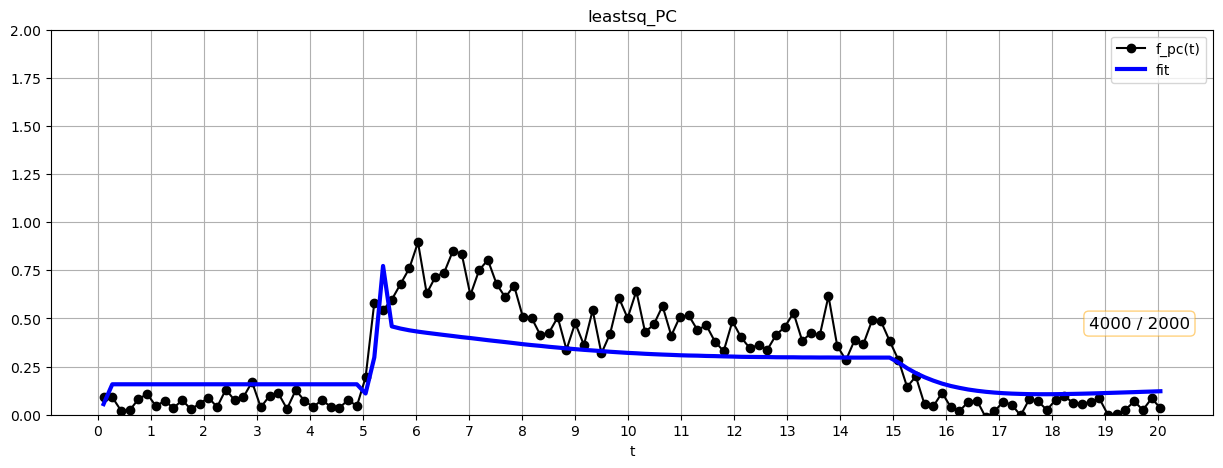


CPU times: total: 1h 36min 4s
Wall time: 1h 36min 38s


In [109]:
%%time
%matplotlib inline
result_powell = minimize(residual_step, params, method='powell', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), max_nfev = 2*max_nfev, nan_policy='propagate', tol=1e-14) #max_nfev = 4*max_nfev,
print()

In [110]:
report_fit(result_powell)

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 4001
    # data points      = 488
    # variables        = 23
    chi-square         = 23.2996539
    reduced chi-square = 0.05010678
    Akaike info crit   = -1438.43593
    Bayesian info crit = -1342.05867
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.43526814 (init = 0.1656221)
    w_1:        0.57248810 (init = 0.7598499)
    w_2:        0.42847403 (init = 0.533095)
    w_3:        1.87761480 (init = 1.955607)
    w_4:        0.61724273 (init = 0.631901)
    w_5:        0.91754606 (init = 0.4144784)
    w_6:        0.46354389 (init = 0.4631842)
    w_7:        1.32048147 (init = 1.055847)
    w_8:        1.53220396 (init = 1.510296)
    w_9:        0.29480613 (init = 0.2501333)
    w_10:       1.81785661 (init = 1.567415)
    w_11:       0.54649373 (init = 0.5941593)
    w_12:       0.06033724 (init = 0.1499703)
    w_13:       0.53136462 (init = 0.6479797)
    w_14:    

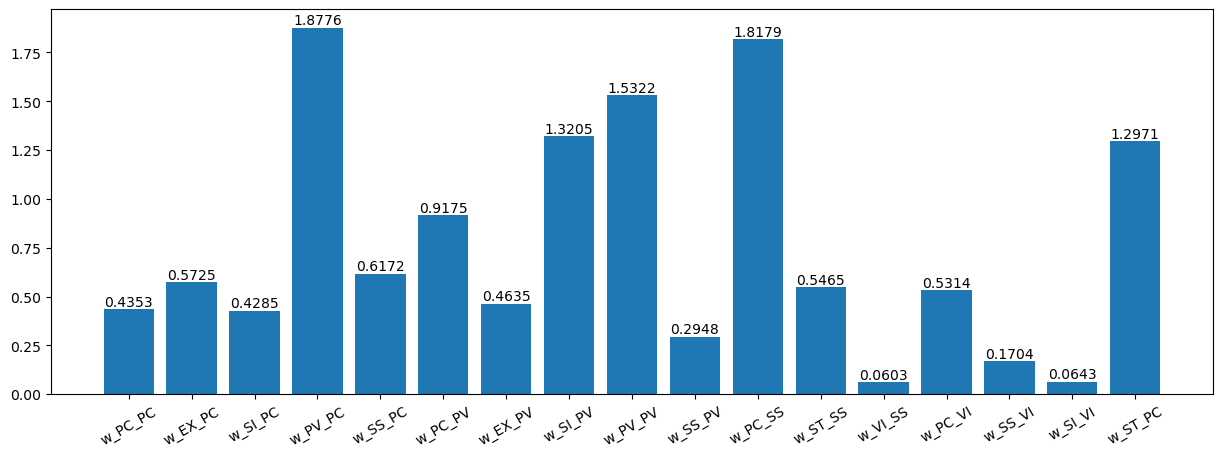

In [111]:
vals = []
for _, param in result_powell.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

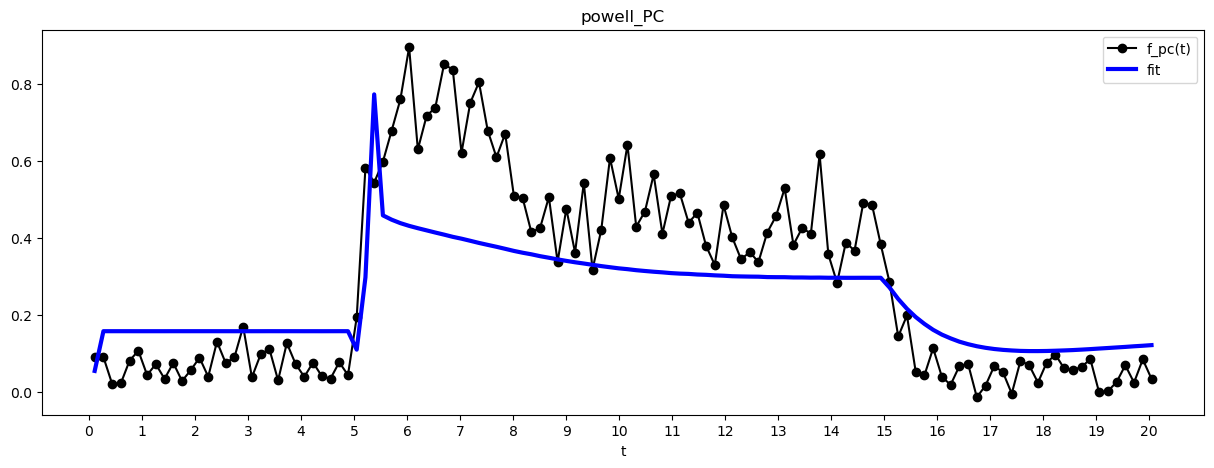

In [112]:
sim_powell = simulate_step(t_exp, init, params)
fit_powell = simulate_step(t_exp, init, result_powell.params)
# step = []

# for i in t_exp:
#     step.append(f_p(i, data_pv_exc))
    
# curve = np.array(step) * result_powell.params['w_1'].value

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_powell['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('powell_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(-0.1, 0.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

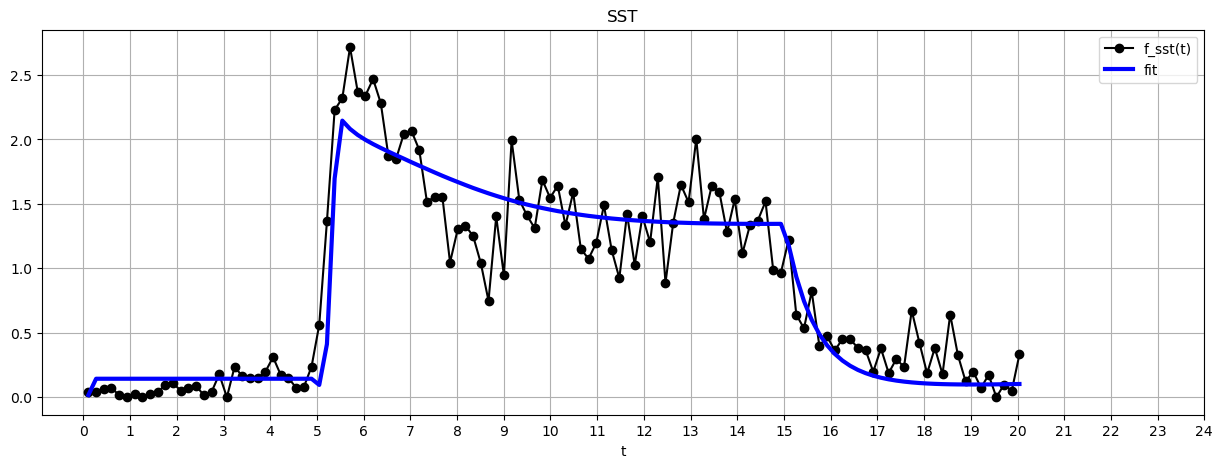

In [113]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_powell['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

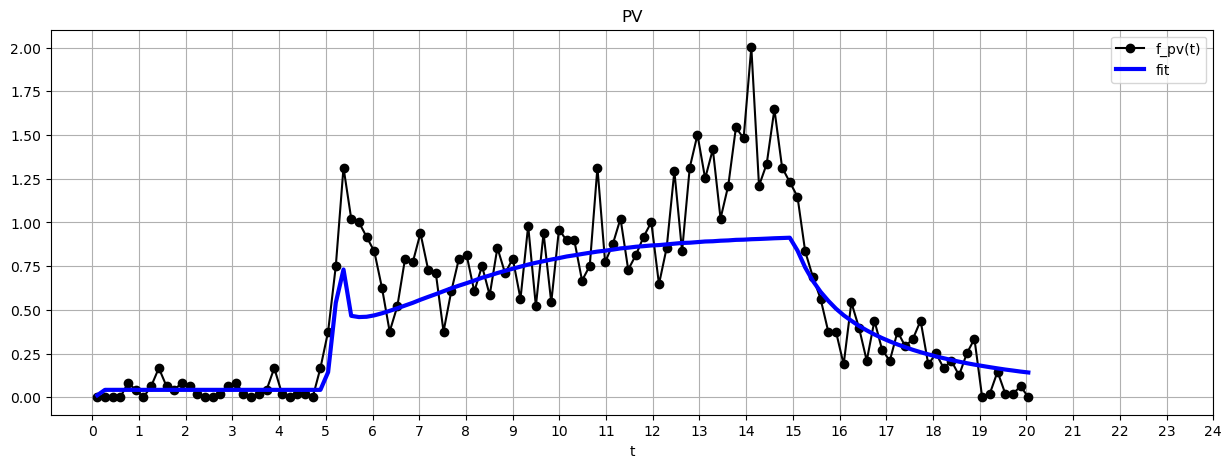

In [114]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_powell['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

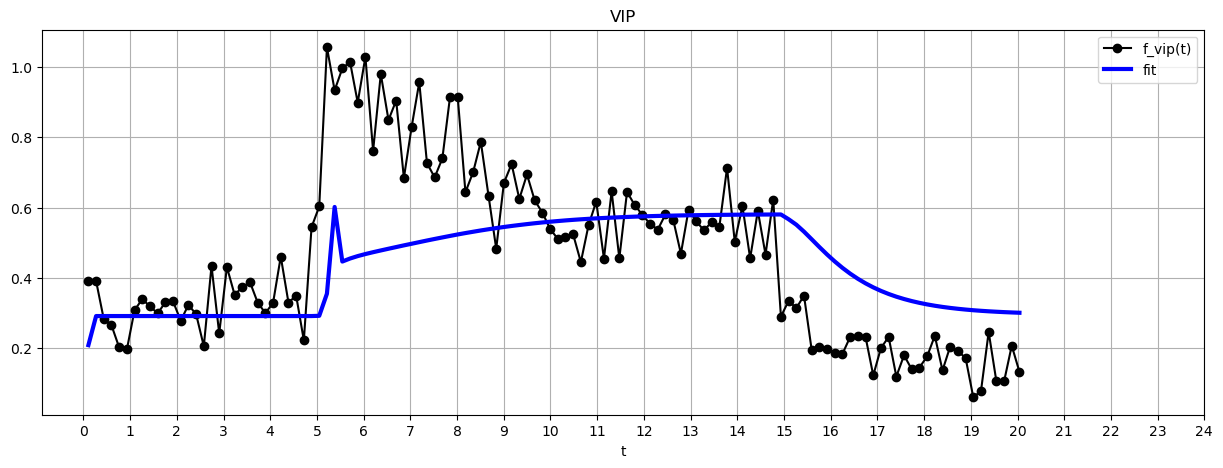

In [115]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_powell['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

# Global_optimization

## bassinhopping

In [116]:
# count = 0


In [117]:
# %%time
# %matplotlib inline
# result_bass = minimize(residual_step, params, method='dual_annealing', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=3*max_nfev)
# print()

In [118]:
# report_fit(result_bass)

In [119]:
# sim_bass = simulate_step(t_exp, init, params)
# fit_bass = simulate_step(t_exp, init, result_bass.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_powell.params['w_1'].value

# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_bass['f_e'].values, color='blue', label='fit', linewidth=3)
# # plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = 'green', label='input')
# plt.title('bass_PC')
# plt.legend(loc='best')
# plt.xlabel('t')
# #plt.ylim(-0.1, 0.6)
# plt.xticks(np.arange(0,21,1))
# #plt.grid()
# plt.show()

In [120]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, sst_new, color='black', marker='o', label='f_sst(t)')
# plt.plot(t_exp, fit_bass['f_sst'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
# plt.title('SST')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [121]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pv_new, color='black', marker='o', label='f_pv(t)')
# plt.plot(t_exp, fit_bass['f_pv'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
# plt.title('PV')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [122]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, vip_new, color='black', marker='o', label='f_vip(t)')
# plt.plot(t_exp, fit_bass['f_vip'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
# plt.title('VIP')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

## ampgo

In [123]:
# count = 0

In [124]:
# %%time
# %matplotlib inline
# result_ampgo = minimize(residual_step, params, method='ampgo', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=4*max_nfev, local = 'Nelder-Mead')
# print()

In [125]:
# report_fit(result_ampgo)

In [126]:
# print(result_ampgo.success)

In [127]:
# sim_ampgo = simulate_step(t_exp, init, params)
# fit_ampgo = simulate_step(t_exp, init, result_ampgo.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_powell.params['w_1'].value

# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_ampgo['f_e'].values, color='blue', label='fit', linewidth=3)
# # plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = 'green', label='input')
# plt.title('ampgo_PC')
# plt.legend(loc='best')
# plt.xlabel('t')
# #plt.ylim(-0.1, 0.6)
# plt.xticks(np.arange(0,21,1))
# #plt.grid()
# plt.show()

In [128]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, sst_new, color='black', marker='o', label='f_sst(t)')
# plt.plot(t_exp, fit_ampgo['f_sst'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
# plt.title('SST')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [129]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pv_new, color='black', marker='o', label='f_pv(t)')
# plt.plot(t_exp, fit_ampgo['f_pv'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
# plt.title('PV')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [130]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, vip_new, color='black', marker='o', label='f_vip(t)')
# plt.plot(t_exp, fit_ampgo['f_vip'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
# plt.title('VIP')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

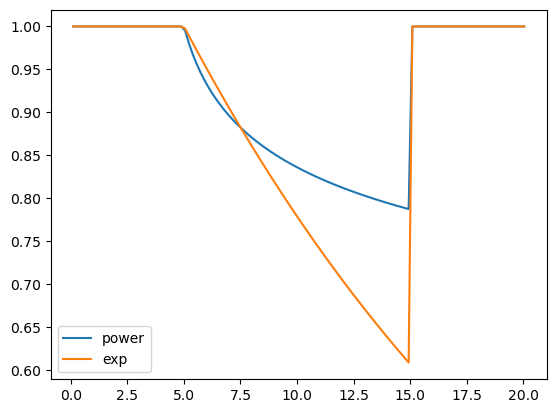

In [131]:
r = []
e = []
for t in t_exp:
    r.append(invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1))
    e.append(exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.05, amp = 1))
    
plt.plot(t_exp, r, label="power")
plt.plot(t_exp, e, label="exp")
plt.legend()
plt.show()